# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
plt.style.use('ggplot')

COLOR_FEMALE = cm.get_cmap("RdBu")(220) # set blue for female
COLOR_MALE = cm.get_cmap("RdBu")(35) # set red for male
TITLE_SIZE = 22
TITLE_PADDING = 10

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [12, 5],
   }
plt.rcParams.update(params)

import pandas as pd
from pandas import json_normalize
pd.options.display.max_rows = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

import copy
import os
import sys
import glob
from shutil import copyfile
from time import time
from datetime import datetime
from tabulate import tabulate
from tqdm.notebook import tqdm

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score

from sklearn import set_config
from sklearn.compose import make_column_transformer
set_config(display='diagram')

import lightgbm as lgb

import umap 

In [3]:
import librosa

In [4]:
import tensorflow as tf
print(f"Using Tensorflow version: {tf.__version__}")
from tensorflow.keras import models, layers, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras import backend as K

Using Tensorflow version: 2.4.0-rc0


# Helper functions

In [5]:
def umap_reduce_and_plot(features, labels, extra_markers=None, title=None, 
                         alpha=1, gender=True, cmap="tab20"):
    
    umapper = umap.UMAP(n_neighbors=25, random_state=1)
    feat_umap = umapper.fit_transform(features)

    plt.figure(figsize=(12,8))
    if gender == True:
        plt.scatter(feat_umap[labels, 0], feat_umap[labels, 1], 
                    color=COLOR_MALE, alpha=alpha)
        plt.scatter(feat_umap[np.invert(labels), 0], feat_umap[np.invert(labels), 1], 
                    color=COLOR_FEMALE, alpha=alpha)

        # https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
        lgd = plt.legend(["male", "female"])
        for lh in lgd.legendHandles: 
            lh.set_alpha(1)
    else:
        plt.scatter(feat_umap[:, 0], feat_umap[:, 1], 
            c=labels, cmap=cmap, alpha=alpha)
        
    if len(extra_markers)>0:
        plt.scatter(feat_umap[extra_markers, 0], feat_umap[extra_markers, 1], 
            c="black", marker="x", s=80)
        
    plt.title(title, size=TITLE_SIZE, pad=TITLE_PADDING)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    return feat_umap

# 1) Model selection and tuning

I load the prepared data, shuffle and split a test set.

In [6]:
def load_prepared_data(language, split=True, n_samples=5_000):
    df_meta = pd.read_parquet(f"_saved_features/_features_step01/cv_{language}_meta.parq")
    df_features = pd.read_parquet(f"_saved_features/_features_step01/cv_{language}_features.parq")
    df_fO = pd.read_parquet(f"_saved_features/_features_step01/cv_{language}_fO.parq")

    # shuffle the data
    df_meta = df_meta.sample(len(df_meta), random_state=42).reset_index(drop=True)
    df_features = df_features.sample(len(df_features), random_state=42).reset_index(drop=True)
    df_fO = df_fO.sample(len(df_fO), random_state=42).reset_index(drop=True)
    
    if "man" in df_fO.columns:
        df_fO.drop("man", axis=1, inplace=True)

    # split MFCC features omitting STFT
    df_mfcc = df_features.iloc[:, 1025:].copy()
    
    converted_mel_bands_to_Hz = librosa.mel_frequencies(n_mels=80, fmin=60, fmax=8000)
    df_mfcc.columns = [f"{x:.0f}" + "_Hz" for x in converted_mel_bands_to_Hz]

    # combine FO and MFCC features
    df_features = pd.concat([df_fO, df_mfcc], axis=1).reset_index(drop=True)
    # drop a couple of recordings for which FO couldn't be calculated 
    df_features.dropna(inplace=True)
    df_meta = df_meta.loc[df_features.index]

    df_meta.reset_index(drop=True, inplace=True)
    df_features.reset_index(drop=True, inplace=True)
    
    # again make sure we have a balanced data set genderwise
    female = df_meta[df_meta.gender=="female"]
    male = df_meta[df_meta.gender=="male"]
    if len(female)<len(male):
        male = male.sample(len(female))
    elif len(female)>len(male):
        female = female.sample(len(male))
    df_meta = pd.concat([male, female])
    df_features = df_features.loc[df_meta.index]

    df_meta.reset_index(drop=True, inplace=True)
    df_features.reset_index(drop=True, inplace=True)
    
    if split==True:
        # split train and test set
        X_train, X_test, y_train, y_test = train_test_split(df_features, 
                                                            df_meta, 
                                                            test_size=n_samples, 
                                                            random_state=42, 
                                                            stratify=df_meta.gender
                                                            )
    
        return X_train, X_test, y_train, y_test
    
    else:
        return df_features, df_meta 

In [7]:
feat_train, feat_test, meta_train, meta_test = load_prepared_data("_german")

## Gridsearching and tuning hyperparameters

- I setup a function that gridsearches a parameter grid, prints out results and returns these for later analysis.
- To save processing time I first search for the best scaler(s) for the classifier and then tune the hyperparameters itself. I hereby try to find and concentrate on the crucial ones, e.g. regularization.


In [8]:
grids = []
test_set_scores = []

In [9]:
CV_FOLDS = 5

def gridsearch_classifier(params_grid):
    # pipeline can be initialized with any valid parameters
    # these aren't used but rather the actual values that come from params_grid
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                           ('estimator', LogisticRegression())])

    # instantiate GridSearchCV, fit on train data, predict on test data
    grid = GridSearchCV(pipe, params_grid, n_jobs=-1, verbose=3, return_train_score=True, cv=CV_FOLDS)
    grid.fit(feat_train, meta_train.gender)
    y_pred = grid.predict(feat_test) 
    accuracy_test_set = accuracy_score(meta_test.gender, y_pred) 
    accuracy_validated = grid.best_score_
    
    print("-"*80)
    print(f"{accuracy_validated:.3f} accuracy validation {CV_FOLDS}fold")
    print(f"{accuracy_test_set:.3f} accuracy on test set\n")
    
    print("Best parameters:")
    print(grid.best_params_)
    print("-"*80)
    
    # prepare data frame with gridsearch results
    results_detailed = pd.DataFrame(grid.cv_results_)
    cols = list(params_grid[0].keys())
    cols = ["param_" + x for x in cols]
    cols = sorted(cols)
    cols.extend(['mean_test_score', 'std_test_score', 'rank_test_score', "mean_fit_time"])
    results_detailed = results_detailed.loc[:, cols]
    results_detailed.param_estimator = results_detailed.param_estimator.apply(lambda x: str(x).split("(")[0])
    results_detailed.columns = results_detailed.columns.str.replace("param_", "")

    # print detailed overview of gridsearch results
    display(results_detailed.sort_values("mean_test_score", ascending=False)
           .style
           .highlight_max(color="lightgreen", subset=["mean_test_score"])
           .highlight_min(color="lightgreen", subset=["std_test_score", "rank_test_score"])
           .background_gradient(cmap='Reds', subset=['mean_fit_time'])
           .hide_index()
           .set_precision(3)
           )
    print()
      
    return grid, accuracy_test_set


def plot_train_test_scores(grid, 
                           param_x_axis, 
                           log_x=False,
                           title="Gridsearch train and validation scores"):
    x = pd.Series(grid.cv_results_[f"param_{param_x_axis}"].data).astype(float)
    y_tr = pd.Series(grid.cv_results_["mean_train_score"]).astype(float)
    y_te = pd.Series(grid.cv_results_["mean_test_score"]).astype(float)
    std_tr = pd.Series(grid.cv_results_["std_train_score"]).astype(float)
    std_te = pd.Series(grid.cv_results_["std_test_score"]).astype(float)
    
    # plot train and test scores
    plt.figure(figsize=(12,5))
    plt.plot(x, y_tr, marker="o", markersize=3)
    plt.plot(x, y_te, marker="o", markersize=3)
    
    if log_x==True:
        plt.xscale("log")

    # plot filled area that shows standard deviation of scores in various folds
    plt.fill_between(x, y_tr+std_tr, y_tr-std_tr, alpha=.5)
    plt.fill_between(x, y_te+std_te, y_te-std_te, alpha=.1)

    # plot marker and annototate best score
    idx_max = y_te.idxmax()
    plt.scatter(x[idx_max], y_te[idx_max], marker='x', c='darkred', zorder=10)
    plt.text(x[idx_max], y_te[idx_max], f" {y_te[idx_max]:.3f} best validation score", fontdict={'size':14})

    plt.legend(["train score", "val score"], bbox_to_anchor=(1.15, 1.01), loc='upper right')
    plt.ylabel("accuracy")
    plt.xlabel(param_x_axis)
    plt.title(title, size=TITLE_SIZE, pad=TITLE_PADDING)
    plt.tight_layout()
    plt.show()

### Evaluating several classifiers, untuned    

From a first overview of classifiers I observe:
- **The non-linear classifiers perform better than the linear ones (with the exception of QDA which ranks low as well).** 
- SVC with kernel `rbf` and KNN achieve the best results. 
- The `rbf` SVC trains comparably slowly.
- QDA, Ridge and Logistic Regression yield good results and very fast training times.
- KNN, LightGBM and HistGradientBoosting seem to be a good compromise between accuracy and speed. 

**I pick Logistic Regression, KNN and LGBM as candidates for hyperparameter tuning.** Although the non linear SVC trains slowly I will tune it too. I am curious how much more accuracy I can achieve. 

In [10]:
classifiers = [
    DummyClassifier(),
    LogisticRegression(),
    RidgeClassifier(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="rbf"),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(),
    HistGradientBoostingClassifier(),
    lgb.LGBMClassifier()
]

In [11]:
%%time
params_grid = [{"scaler": [StandardScaler()],
                'estimator': classifiers,
               }]

_, _ = gridsearch_classifier(params_grid)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
--------------------------------------------------------------------------------
0.973 accuracy validation 5fold
0.978 accuracy on test set

Best parameters:
{'estimator': SVC(), 'scaler': StandardScaler()}
--------------------------------------------------------------------------------



CPU times: user 23 s, sys: 364 ms, total: 23.3 s
Wall time: 3min 11s


In [12]:
# get scores for all untuned classifiers on test set for final overview
for clf in classifiers:
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(feat_train, meta_train.gender)
    test_score = pipe.score(feat_test, meta_test.gender)
    grids.append(None)
    test_set_scores.append([str(clf).replace("()", "").replace("Classifier",""), "untuned", test_score])

### Tuning Logistic regression  
- The tuning yields only a slight improvement of +0.002 accuracy validated compared to the defaults/untuned.
- The optimal value for C is 0.26 which is a higher regularization than the default of 1. (C being the inverse of regularization strength. Like in support vector machines, smaller values specify stronger regularization.)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
--------------------------------------------------------------------------------
0.950 accuracy validation 5fold
0.951 accuracy on test set

Best parameters:
{'estimator': LogisticRegression(C=0.2592943797404667, max_iter=1000.0), 'estimator__C': 0.2592943797404667, 'scaler': QuantileTransformer()}
--------------------------------------------------------------------------------


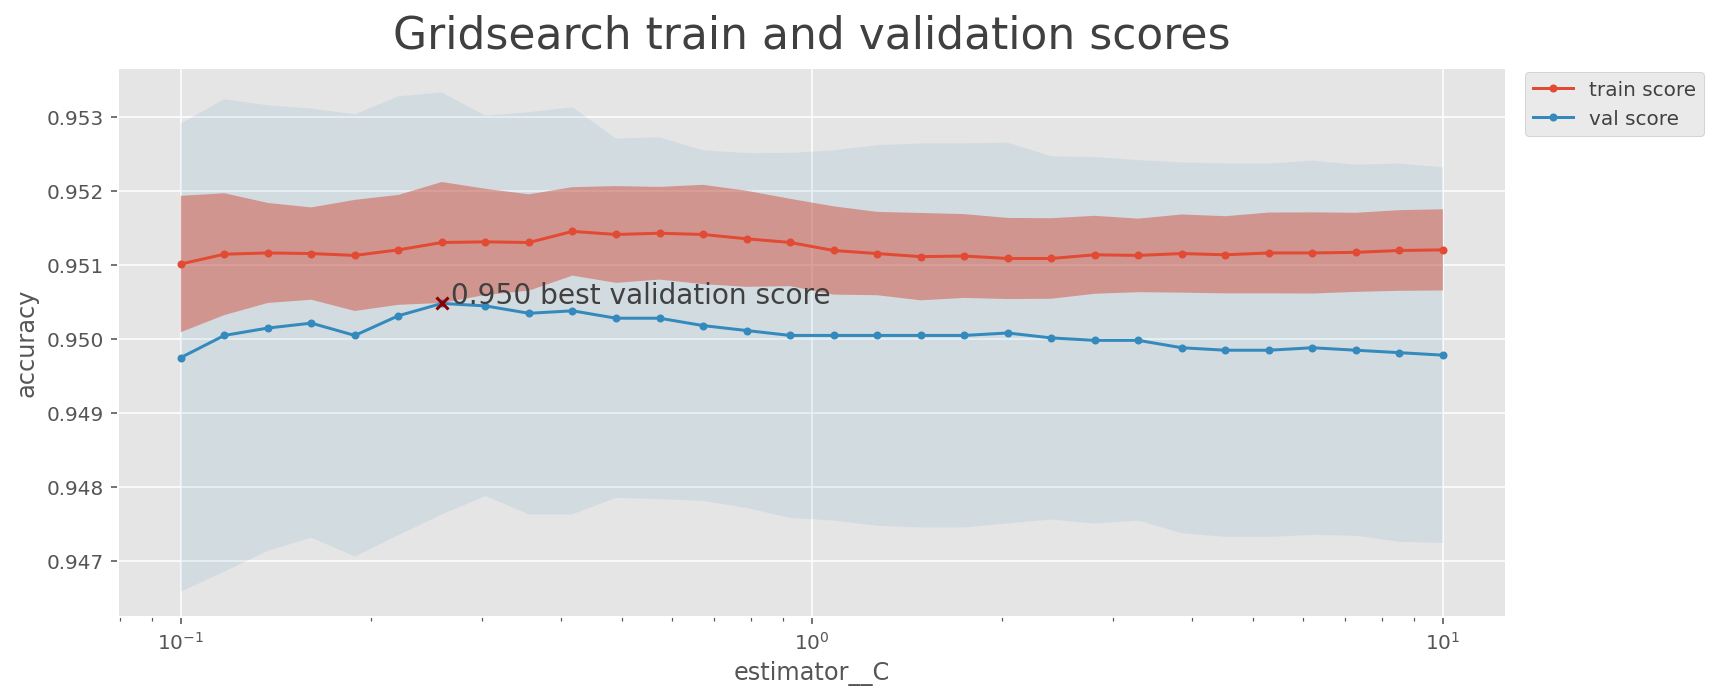

CPU times: user 4.33 s, sys: 1.8 s, total: 6.12 s
Wall time: 25.8 s


In [13]:
%%time
params_grid = [{"scaler": [
#                            MinMaxScaler(),
#                            StandardScaler(), 
#                            RobustScaler(), 
                           QuantileTransformer(), 
#                            PowerTransformer(), 
                           ],
                'estimator':[LogisticRegression(max_iter=1e3)],
                'estimator__C': np.logspace(-1, 1, 30),
                }
              ]

grid, accuracy_test_set = gridsearch_classifier(params_grid)
grids.append(grid)
test_set_scores.append(["LogisticRegression", "tuned", accuracy_test_set])
plot_train_test_scores(grid, param_x_axis="estimator__C", log_x=True)

### Tuning KNN
- Tuning KNN yields +0.009 accuracy validated.
- **The results on the test set are very good: 0.982**
- The optimal value 4 for `n_neighbors` lies very close to the classifier's default of 5. 
- `distance` as the weighing factor performs slightly better than `uniform`. 


**It is interesting to see that the *train* score is always 1 regardless of the number of neighbors.** The reason for this pecularity lies in the chosen value `distance` (rather than the default `uniform`) for hyperparameter `weights`. 
- The default `uniform` means that every neighbor has equal voting rights. The first neighbor for a *training sample* is always the sample itself, resulting in a perfect train score of 1 for `n_neighbors=1`. The more neighbors vote the higher the errors will be. 
- With value `distance` on the other hand the estimator **weighs points by the inverse of their distance.** Closer neighbors of a query point will have a greater influence than neighbors which are further away. Since the first neighbor of a *train* sample always is the sample itself and the inverse of distance 0 is basically infinite in the sense that it cannot be calculated, the other neighbors do not matter anymore in their voting resulting in this unchanging train score of 1.

This pecularity has no influence on the training or model quality. Training is just fine as we can see from the validation score and results on the test set.

Fitting 5 folds for each of 10 candidates, totalling 50 fits
--------------------------------------------------------------------------------
0.980 accuracy validation 5fold
0.982 accuracy on test set

Best parameters:
{'estimator': KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance'), 'estimator__metric': 'manhattan', 'estimator__n_neighbors': 4, 'estimator__weights': 'distance', 'scaler': QuantileTransformer()}
--------------------------------------------------------------------------------


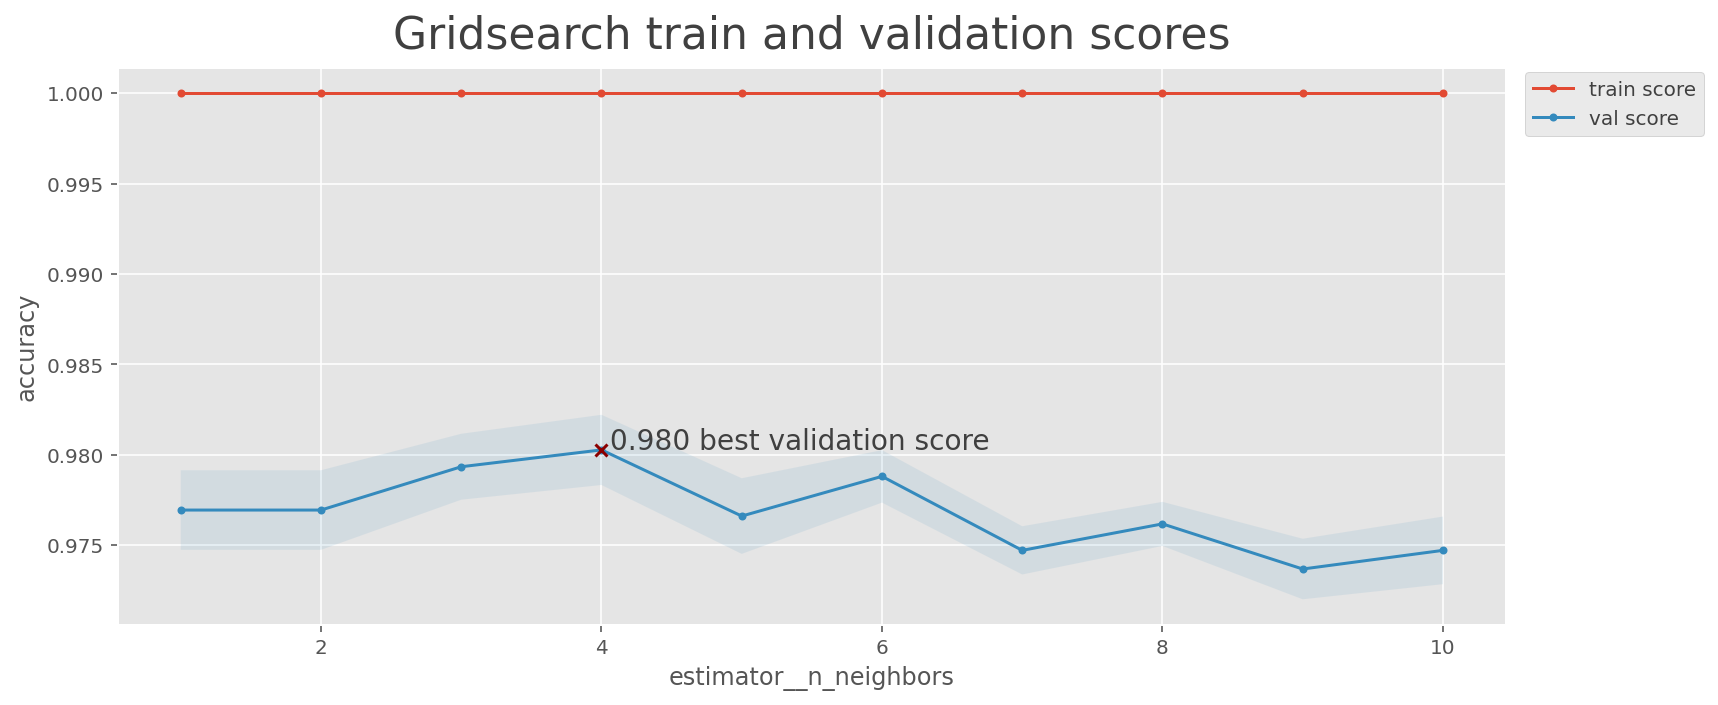

CPU times: user 9.59 s, sys: 433 ms, total: 10 s
Wall time: 8min 57s


In [14]:
%%time
params_grid = [{"scaler": [
#                            MinMaxScaler(),
#                            StandardScaler(), 
#                            RobustScaler(), 
                           QuantileTransformer(), 
#                            PowerTransformer(), 
                           ],
                'estimator':[KNeighborsClassifier()],
                'estimator__n_neighbors': np.linspace(1, 10, 10, dtype="int"),
                "estimator__weights": ['distance'],
                "estimator__metric": ['manhattan'],
                }
              ]

grid, accuracy_test_set = gridsearch_classifier(params_grid)
grids.append(grid)
test_set_scores.append(["KNeighbors", "tuned", accuracy_test_set])
plot_train_test_scores(grid, param_x_axis="estimator__n_neighbors")

### Tuning LGBM
- Tuning the LGBM classifier results in +0.01 improvement. 
- In general **more estimators and a smaller learning rate yield better results** (up to a certain point).
- The training times get substiantially longer (the more estimators and the lower the learning rate the longer the training does take).

Fitting 5 folds for each of 25 candidates, totalling 125 fits
--------------------------------------------------------------------------------
0.972 accuracy validation 5fold
0.978 accuracy on test set

Best parameters:
{'estimator': LGBMClassifier(learning_rate=0.11006941712522098, n_estimators=2500), 'estimator__learning_rate': 0.11006941712522098, 'estimator__n_estimators': 2500, 'scaler': QuantileTransformer()}
--------------------------------------------------------------------------------


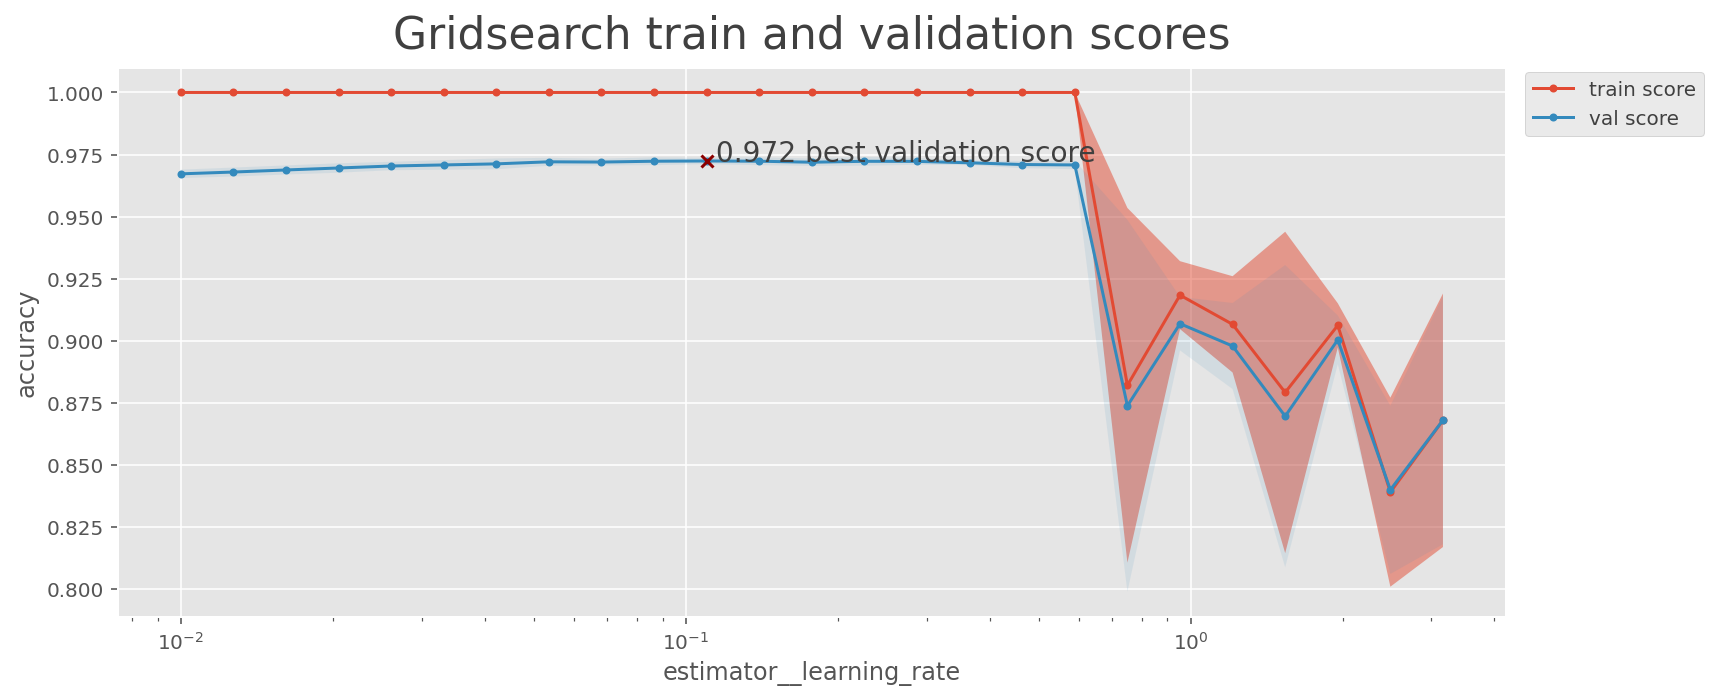

CPU times: user 54.4 s, sys: 11.6 s, total: 1min 5s
Wall time: 8min 58s


In [15]:
%%time
params_grid = [{"scaler": [
#                            MinMaxScaler(),
#                            StandardScaler(), 
#                            RobustScaler(), 
                           QuantileTransformer(), 
#                            PowerTransformer(), 
                           ],
                'estimator':[lgb.LGBMClassifier()],
                'estimator__n_estimators': [2500],
                "estimator__learning_rate": np.logspace(-2, 0.5, 25),
                }
              ]

grid, accuracy_test_set = gridsearch_classifier(params_grid)
grids.append(grid)
test_set_scores.append(["LGBM", "tuned", accuracy_test_set])
plot_train_test_scores(grid, param_x_axis="estimator__learning_rate", log_x=True)

### Tuning SVC
- Tuning SVC yields +0.006 accuracy validated.
- SVC gains from less regularization than the default (`C`=7 vs `C`=1).

Fitting 5 folds for each of 20 candidates, totalling 100 fits
--------------------------------------------------------------------------------
0.979 accuracy validation 5fold
0.981 accuracy on test set

Best parameters:
{'estimator': SVC(C=7.386199822079358), 'estimator__C': 7.386199822079358, 'scaler': StandardScaler()}
--------------------------------------------------------------------------------


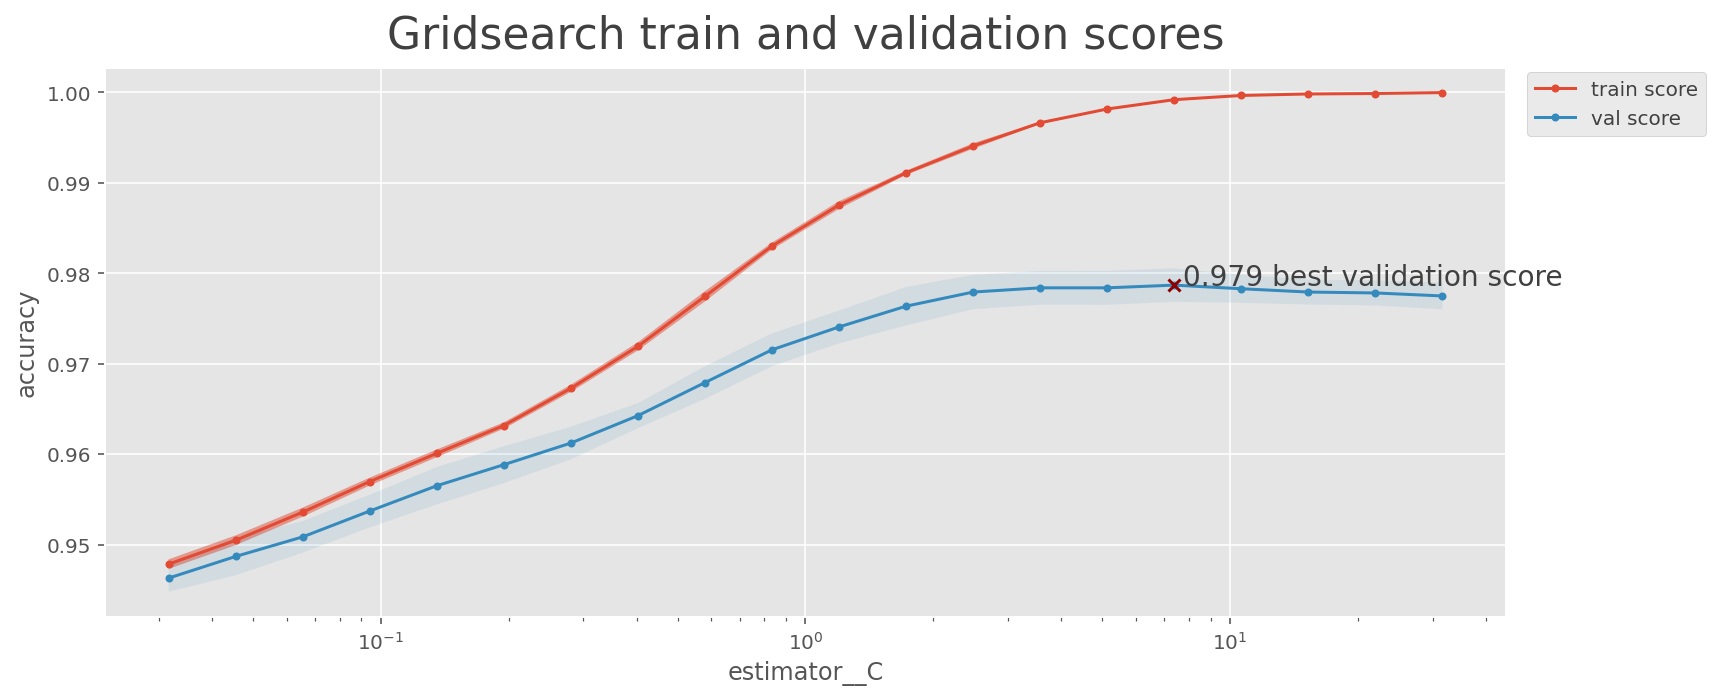

CPU times: user 43.2 s, sys: 443 ms, total: 43.7 s
Wall time: 17min 20s


In [16]:
%%time
params_grid = [{"scaler": [
#                            MinMaxScaler(),
                           StandardScaler(), 
#                            RobustScaler(), 
#                            QuantileTransformer(), 
#                            PowerTransformer(), 
                           ],
                'estimator':[SVC(kernel="rbf")],
                'estimator__C': np.logspace(-1.5, 1.5, 20),
                }
              ]

grid, accuracy_test_set = gridsearch_classifier(params_grid)
grids.append(grid)
test_set_scores.append(["SVC", "tuned", accuracy_test_set])
plot_train_test_scores(grid, param_x_axis="estimator__C", log_x=True)

### Evaluating the results of the tuned models

- **Tuning the selected models only brought marginal improvements** – for KNN e.g. it is just +0.009 accuracy.
- **KNN yields the best results** (validated and on the test data set). **It trains very fast too.**
- **SVC comes in as the second best classifier.** It trains slower in comparison to all other classifiers. **Inference performance is more interesting for my task** if I want to predict on hundreds of hours of podcast audio.

In [17]:
df = pd.DataFrame(test_set_scores, columns=["classifier", "tuned", "accuracy"])
print("Ranked results from GridsearchCV")
display(df.sort_values("accuracy", ascending=False)
           .style
           .highlight_max(color="lightgreen")
           .hide_index()
           .set_precision(3)
       )

Ranked results from GridsearchCV


## Ensembling with meta classifiers

**Ensemble methods combine the predictions of several estimators to improve generalizability and robustness of the final model.**

- A [**stacking classifier**](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization) combines estimators to reduce their biases. The predictions of each individual estimator are stacked together and used as input to a final estimator – in my case I choose a Logistic regression – to compute the prediction.
- A [**voting classifer**](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) combines *«conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels.»* This classifier is meant to be *«useful for a set of equally well performing model in order to balance out their individual weaknesses.»*

Trying the two methods I observe:
- **The stacking classifer does improve the best result from KNN slightly (+0.005).** 
- The voting classifier ranks worse than KNN or SVC itself. Setting voting from `hard` to `soft` didn't improve results.  
- **Training of and inference with the Stacking classifier takes a lot of training time** (all inidividual estimators have to be trained and are being used for inference including the classifier on top of the ensemble as well).

In [18]:
%%time
estimators = [
             ('lgr', make_pipeline(QuantileTransformer(), 
                                   LogisticRegression(max_iter=1e3, 
                                                      C=0.26, 
                                                      n_jobs=-1
                                                      ))),
             ('knn', make_pipeline(QuantileTransformer(), 
                                   KNeighborsClassifier(n_neighbors=4, 
                                                        weights="distance", 
                                                        metric="manhattan",
                                                        n_jobs=-1
                                                        ))),
             ('lgb', make_pipeline(QuantileTransformer(), 
                                   lgb.LGBMClassifier(learning_rate=0.14, 
                                                      n_estimators=2500,
                                                      ))),
             ('svc', make_pipeline(StandardScaler(), 
                                   SVC(C=7.3))),
            ]

CPU times: user 445 µs, sys: 133 µs, total: 578 µs
Wall time: 194 µs


In [19]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
scores = cross_val_score(clf, feat_train, meta_train.gender, cv=5, n_jobs=-1, verbose=1)

start = time()
clf.fit(feat_train, meta_train.gender)
y_pred = clf.predict(feat_test) 
accuracy_validated = np.mean(scores)
accuracy_test_set = accuracy_score(meta_test.gender, y_pred)
test_set_scores.append(["StackingClf", "tuned", accuracy_test_set])

print(f"{accuracy_validated:.3f} accuracy CV 5fold")
print(f"{accuracy_test_set:.3f} accuracy on test set\n")
print(f"Training took {(time()-start)/60:.1f} minutes")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.9min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


0.984 accuracy CV 5fold
0.987 accuracy on test set

Training took 2.5 minutes


In [20]:
clf = VotingClassifier(estimators=estimators, voting="hard", n_jobs=-1)
scores = cross_val_score(clf, feat_train, meta_train.gender, cv=5, n_jobs=-1, verbose=1)

start = time()
clf.fit(feat_train, meta_train.gender)
y_pred = clf.predict(feat_test) 
accuracy_validated = np.mean(scores)
accuracy_test_set = accuracy_score(meta_test.gender, y_pred)
test_set_scores.append(["VotingClf", "tuned", accuracy_test_set])

print(f"{accuracy_validated:.3f} accuracy CV 5fold")
print(f"{accuracy_test_set:.3f} accuracy on test set\n")
print(f"Training took {(time()-start)/60:.1f} minutes")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


0.977 accuracy CV 5fold
0.979 accuracy on test set

Training took 0.9 minutes


## Training a dense neural network

In comparision to the scikit classifiers I want to see how a dense neural network performs on the data.
- I train DNNs with 1, 2 and 3 hidden layers. 
- I evaluate various hidden layer sizes between 2 and 1024 dense units.
- I tried dropout with different fraction values to reduce overfitting.

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(feat_train, 
                                                      np.where(meta_train.gender=="male", True, False), 
                                                      test_size=0.1, random_state=1)
X_test = feat_test
y_test = np.where(meta_test.gender=="male", True, False)

# scale the data explicitly because I won't use a pipeline here
# use a QuantileTransformer rather than the StandardScaler
# Quantile performed best on Logistic regression which has the same decision function (sigmoid) 
# that we need to use for the DNN here too
scaler = QuantileTransformer()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_valid = minmax.transform(X_valid)
X_test = minmax.transform(X_test)

In [22]:
results = []
EPOCHS = 150
MAX_HIDDEN_LAYERS = 3

for no_hidden in range(1, MAX_HIDDEN_LAYERS+1):
    for dense_units in tqdm([2, 8, 32, 128, 512, 1024]):
        model = models.Sequential()
        model.add(layers.Input(shape=(85)))
        for _ in range(0, no_hidden):
            model.add(layers.Dense(dense_units, activation='relu'))
        model.add(layers.Dense(1, activation="sigmoid"))
        model.compile(optimizer=optimizers.Adam(), 
                      loss=losses.binary_crossentropy,
                      metrics=["accuracy"])

        early_stopping_callback = EarlyStopping(verbose=False, patience=50, 
                                                restore_best_weights=False)

        history = model.fit(X_train, y_train, 
                            validation_data=(X_valid, y_valid), 
                            epochs=EPOCHS, 
                            batch_size=64, 
                            verbose=False, 
                            shuffle=True, 
                            workers=8, 
                            callbacks=[early_stopping_callback]
                           )

        y_pred = model.predict(X_test)
        y_pred = [True if x>0.5 else False for x in y_pred]
        accuracy_test_set = balanced_accuracy_score(y_test, y_pred)
        test_set_scores.append([f"DNN {no_hidden}/{dense_units}", "tuned", accuracy_test_set])

        df_history = pd.DataFrame(history.history)
        df_history["dense_units"] = dense_units
        df_history["hidden_layers"] = no_hidden
        df_history["accuracy_test_set"] = accuracy_test_set
        results.append(df_history)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

- **The larger the network the more it is able to train into overfitting** (which is to be expected).
- Scaling the data with the QuantileTransformer works considerably better than standard scaling. Training seems much more stable, is faster and yields better results.
- A very minimal network of just two neurons already achieves 0.957 accuracy.
- **A DNN with 3 hidden layers and 512 or 1024 dense units performs best with 0.979 accuracy on the test set**.
- **The results are good** in comparison to the other estimators. **However, the DNNs do not outperform the best ranking KNN and SVC classifiers**.

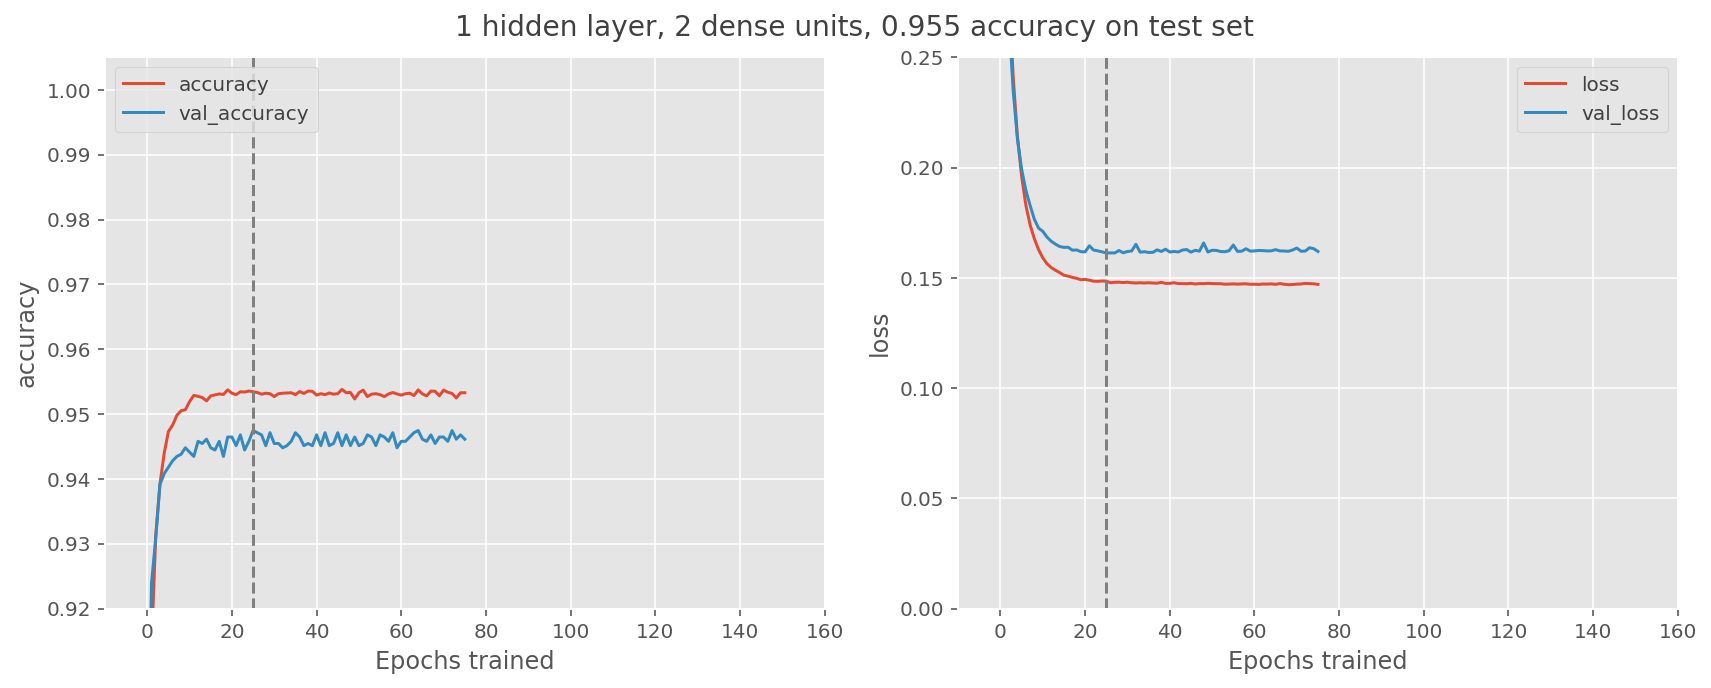

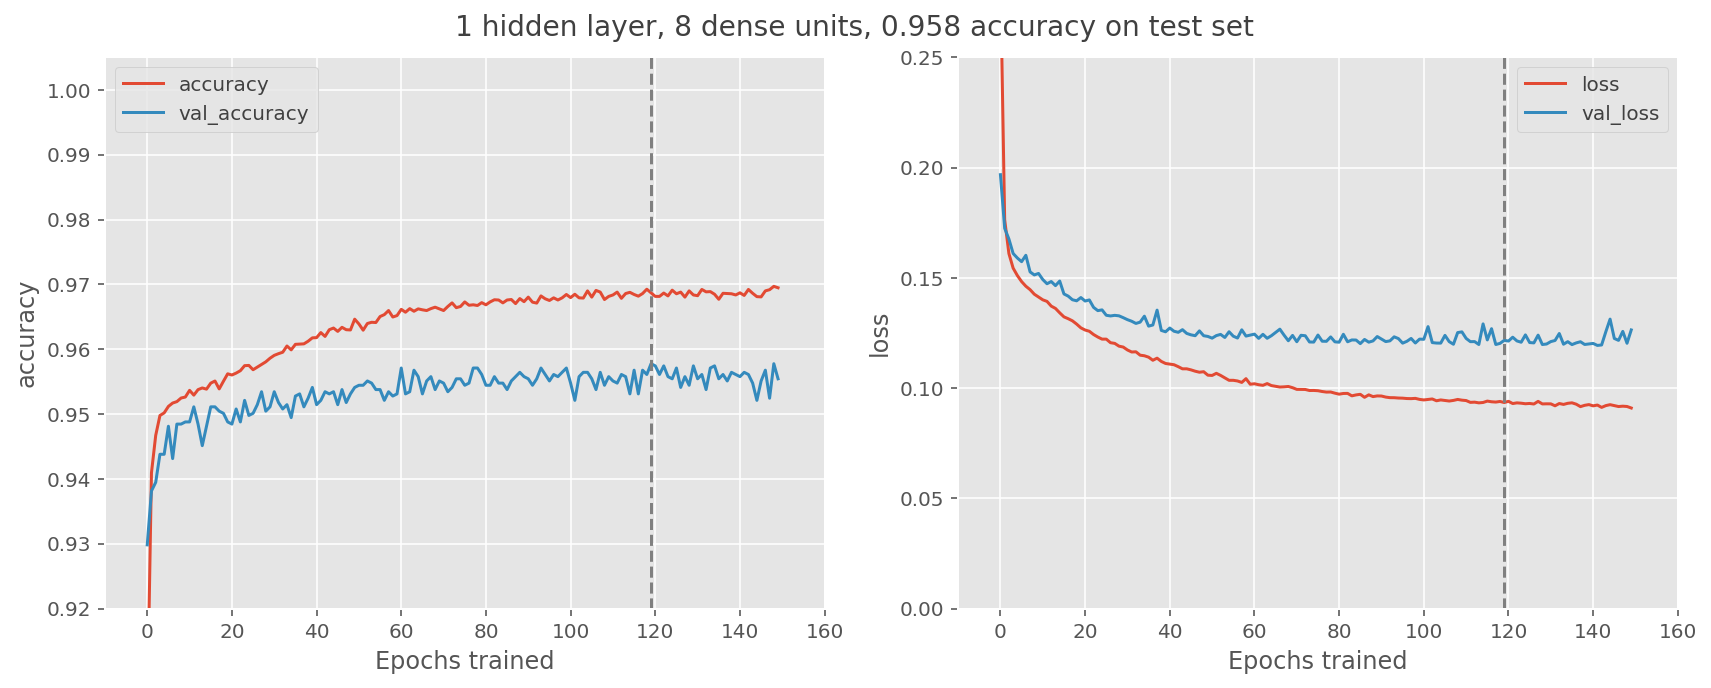

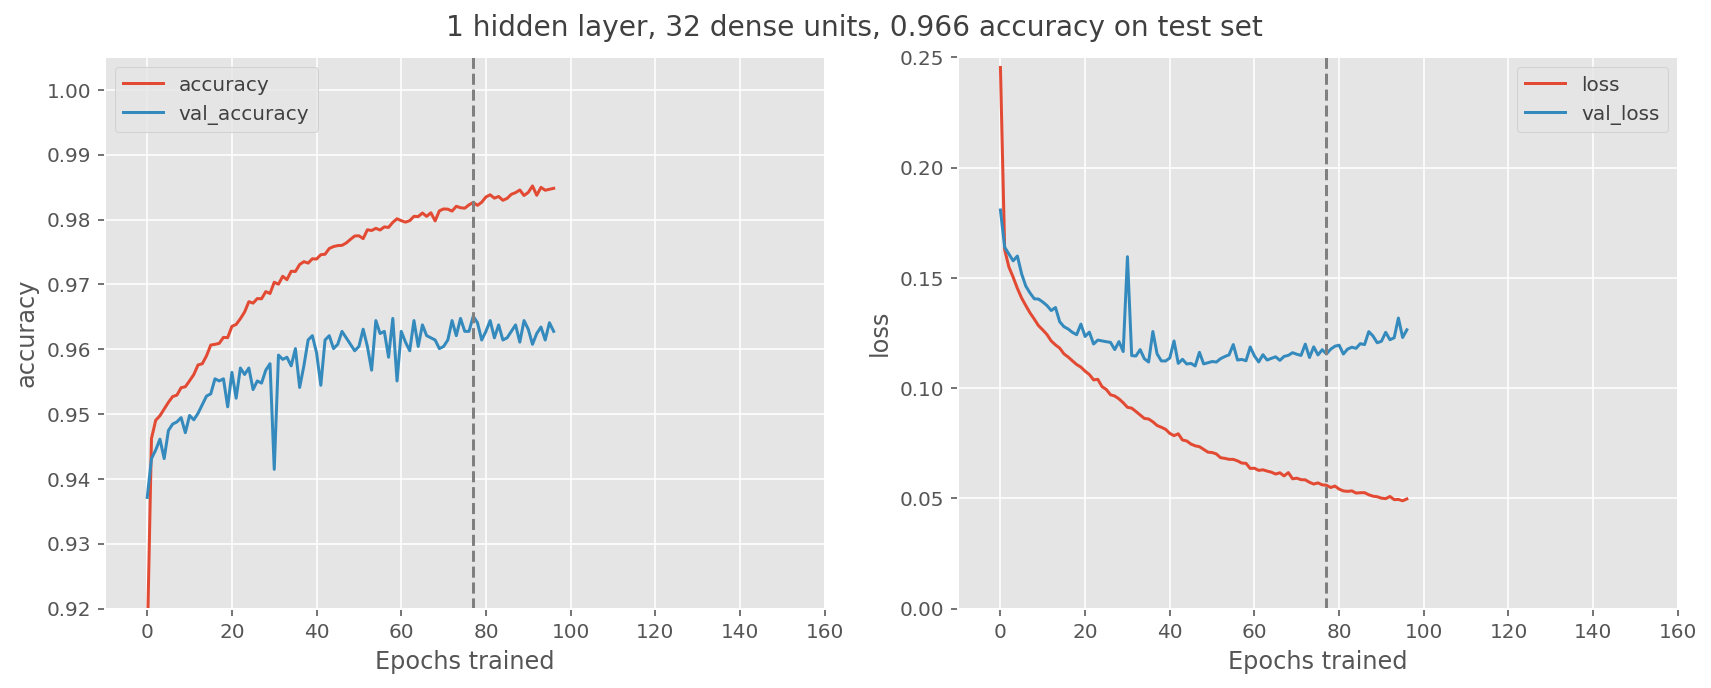

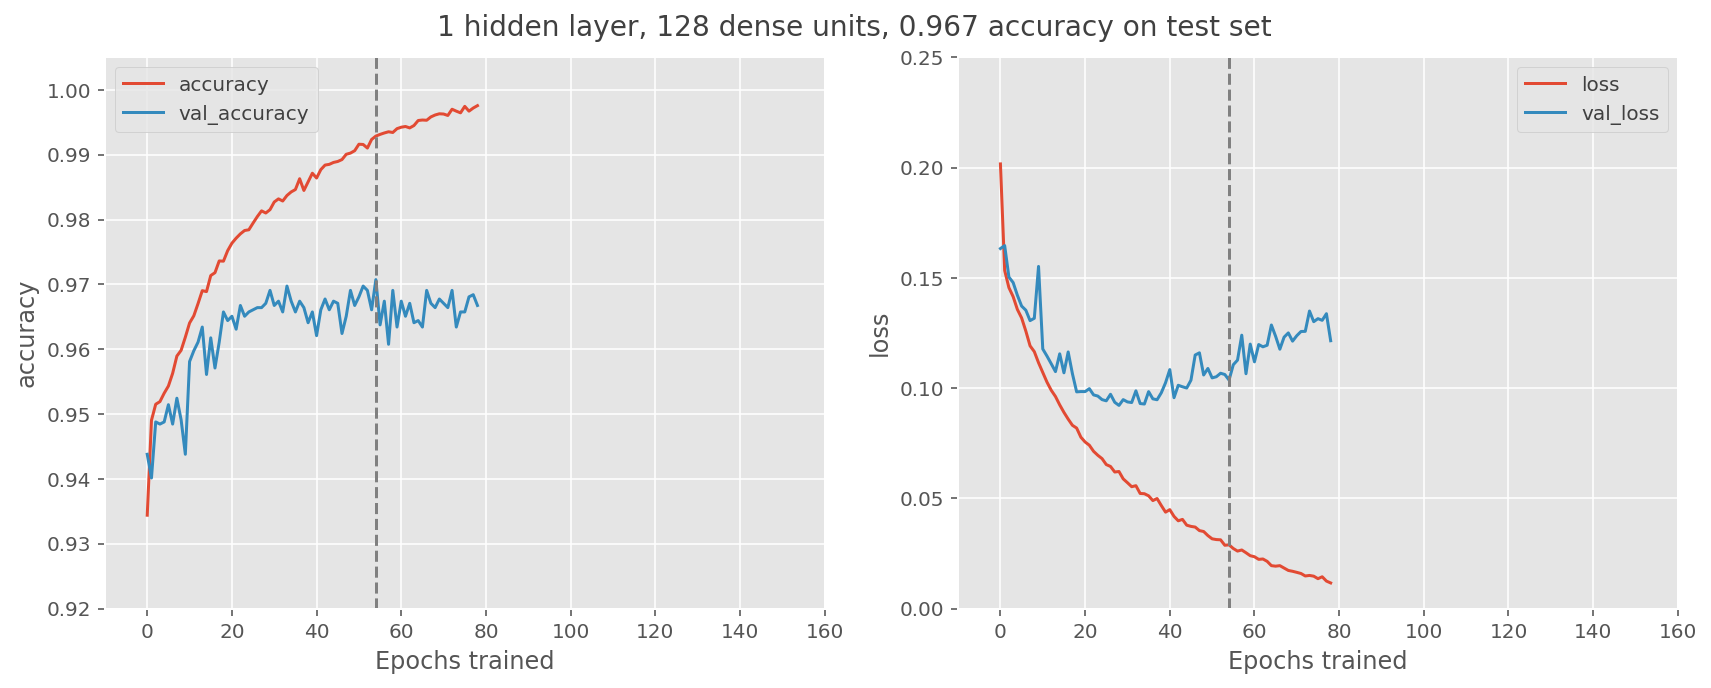

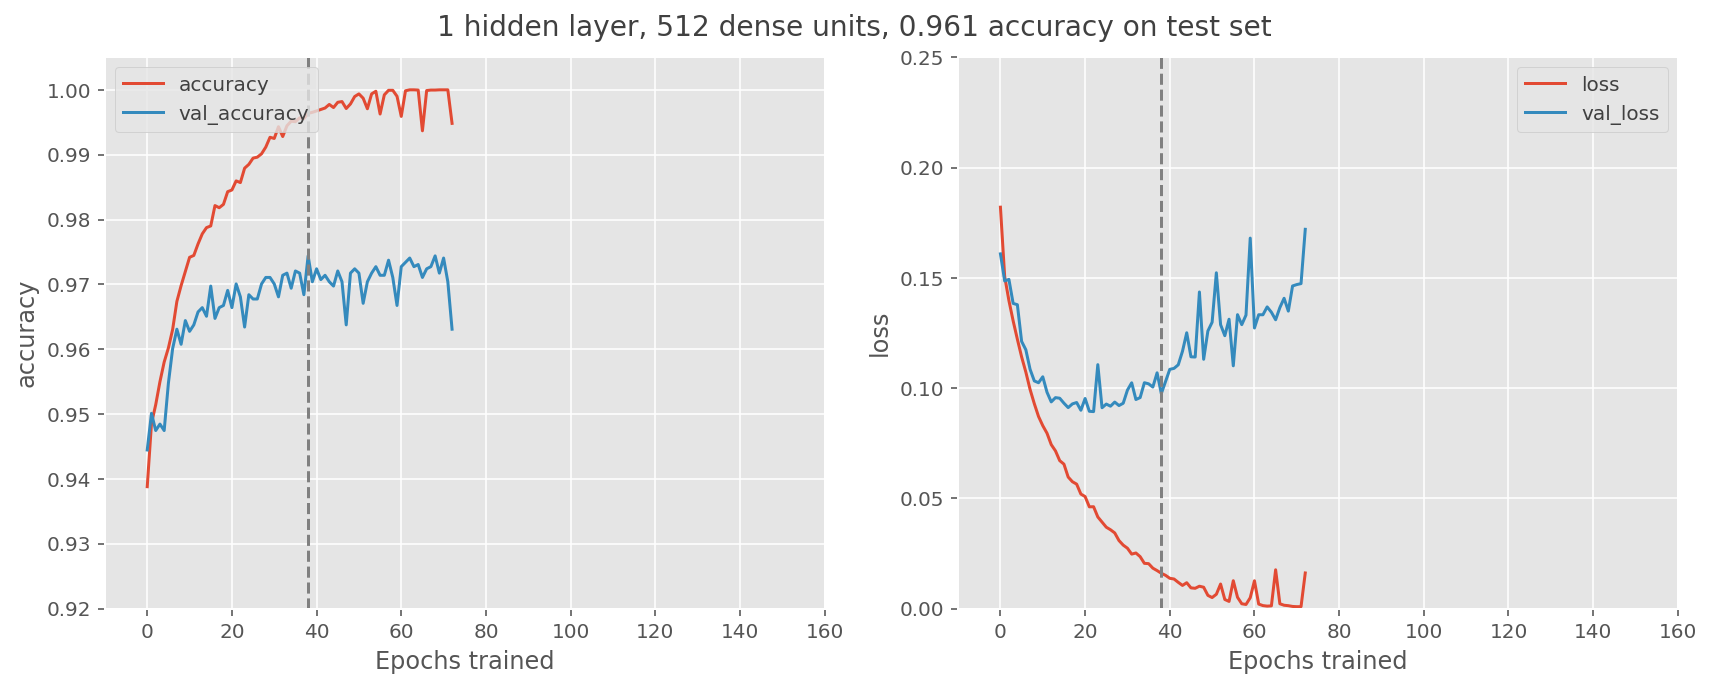

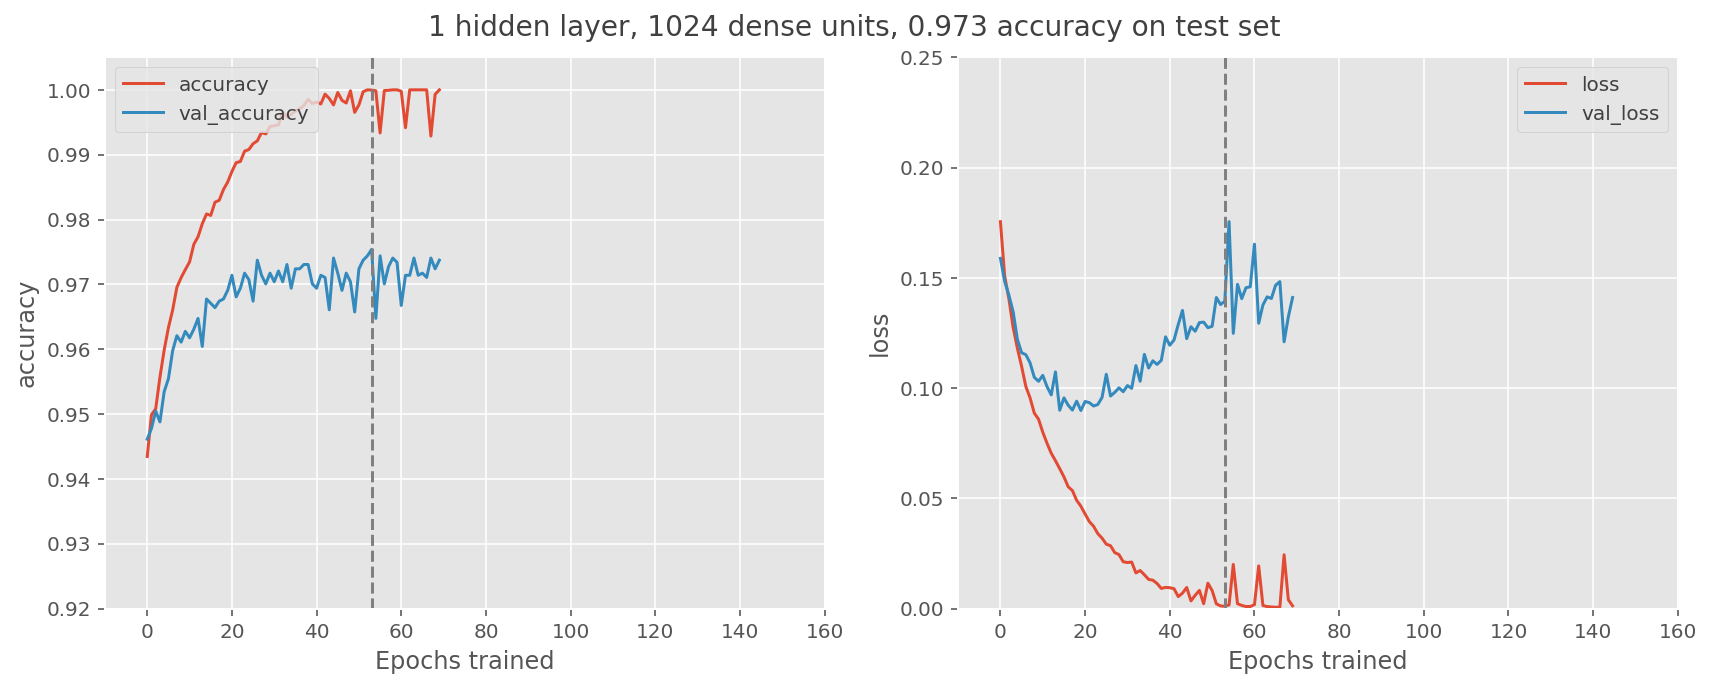

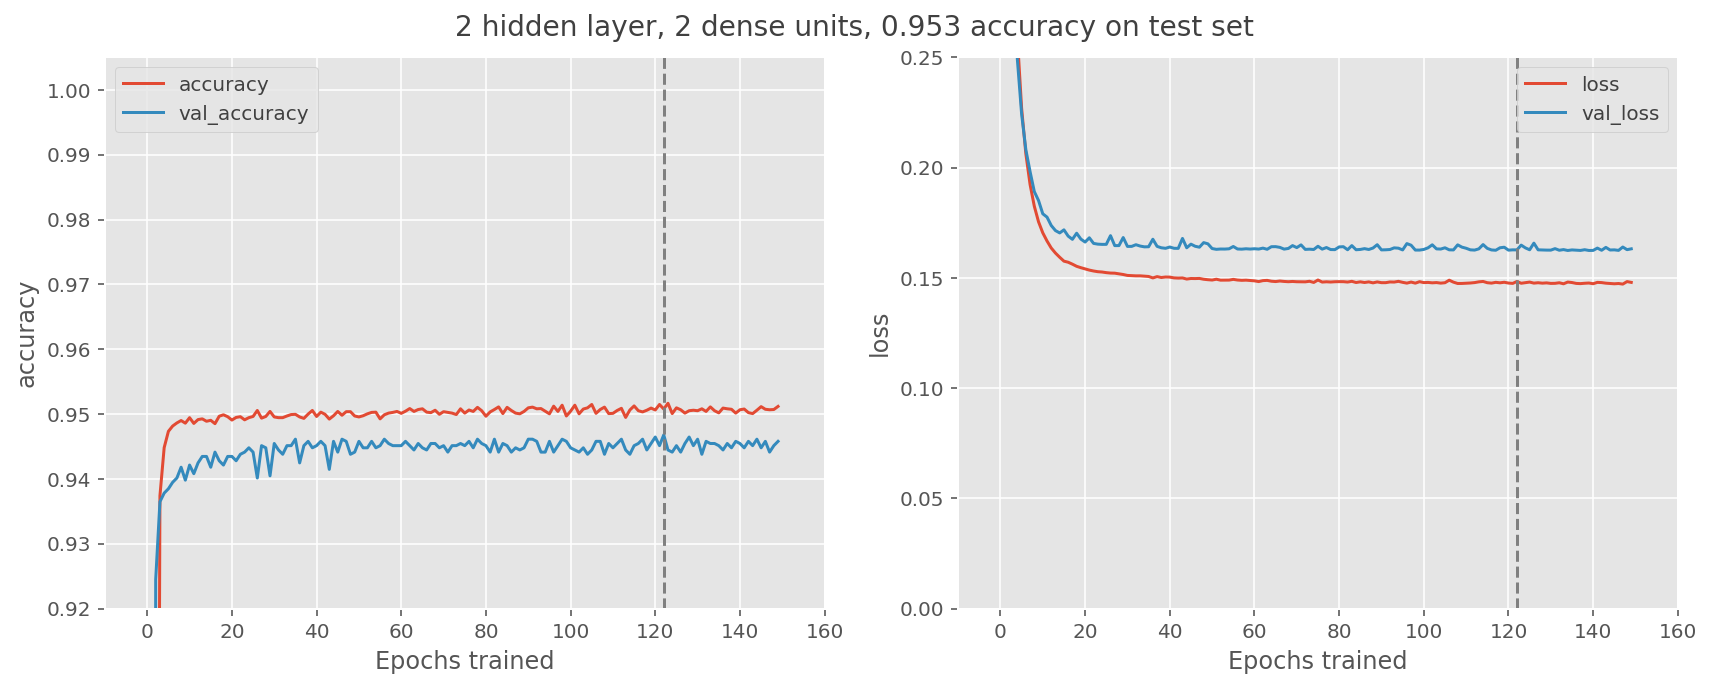

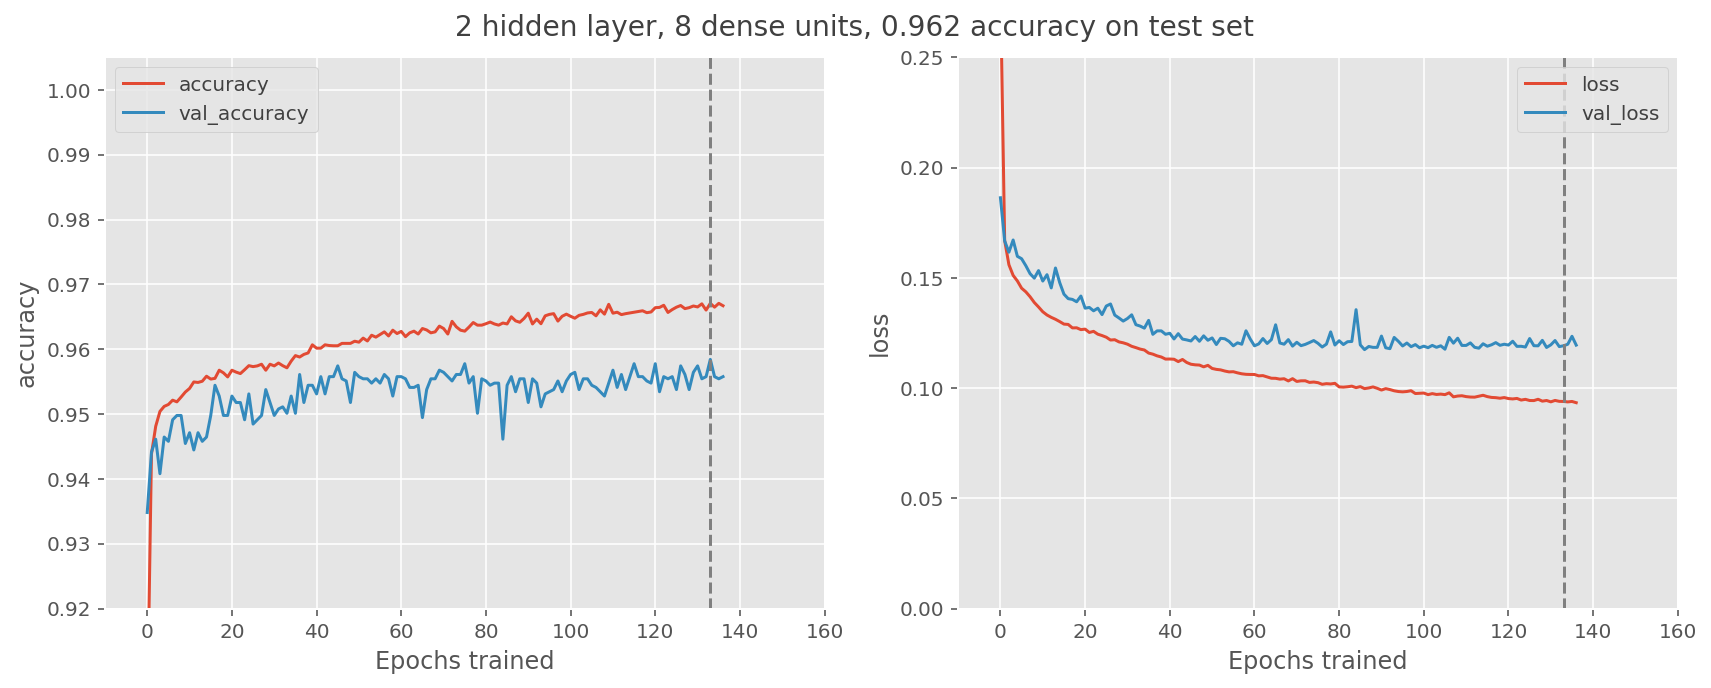

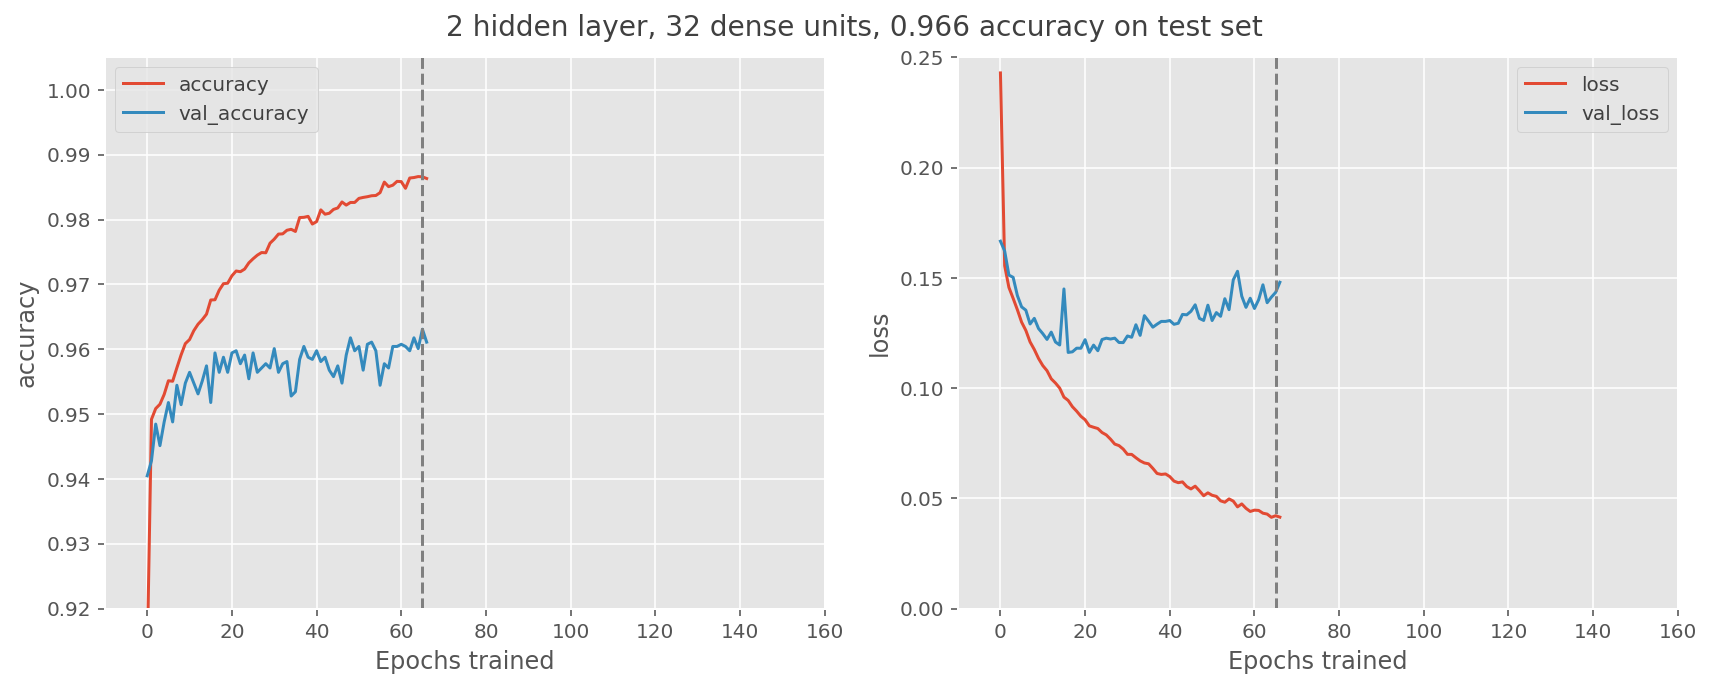

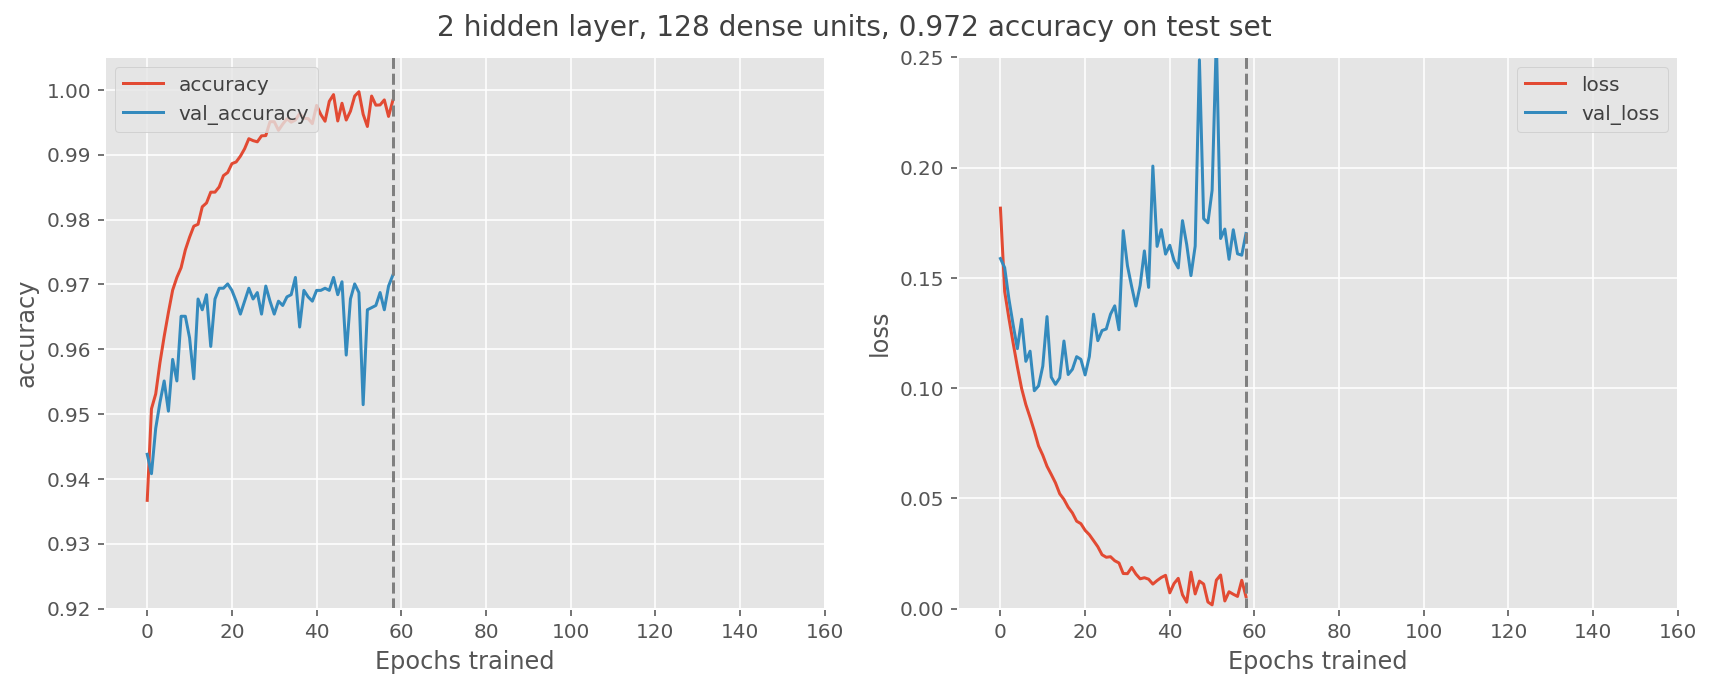

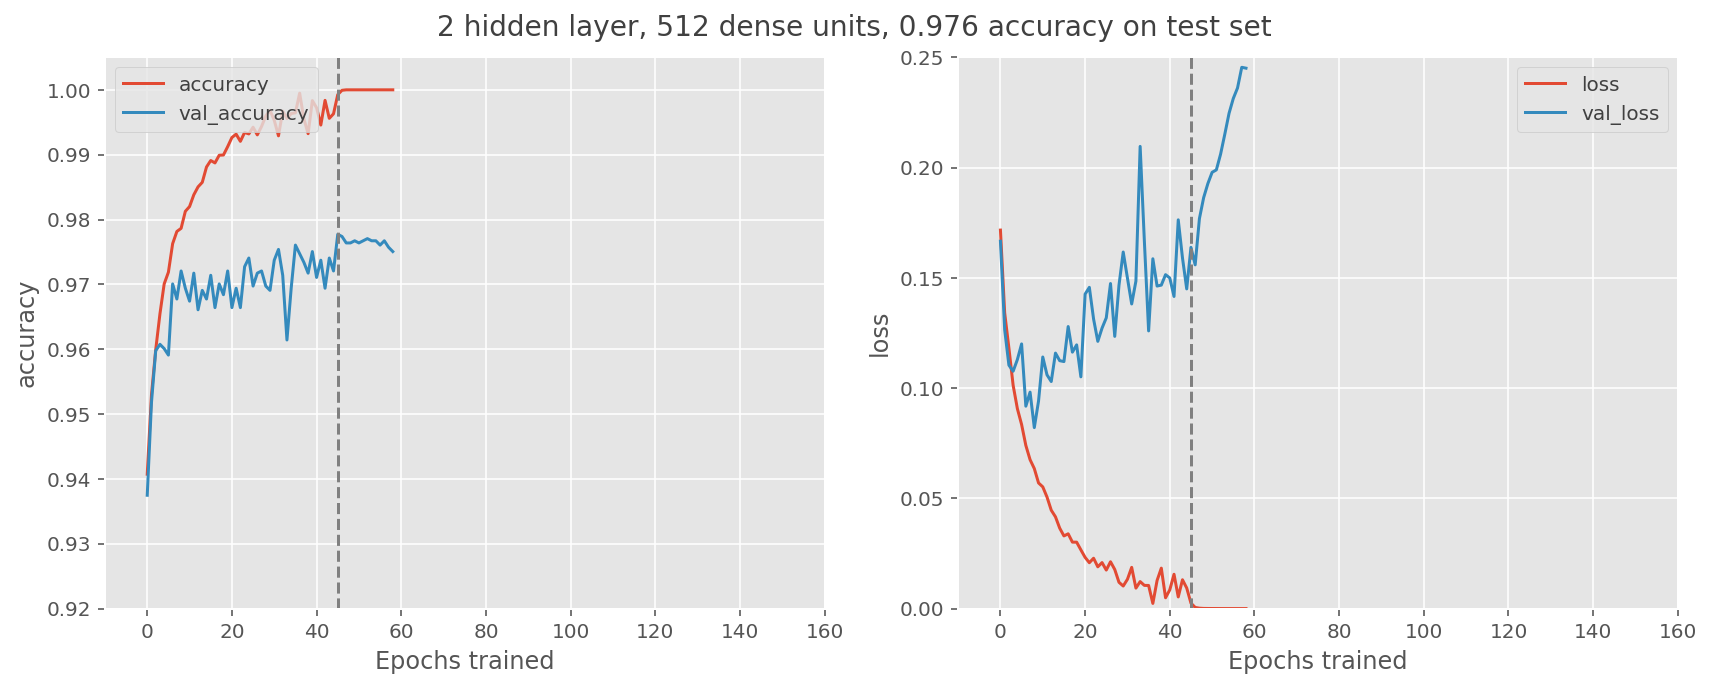

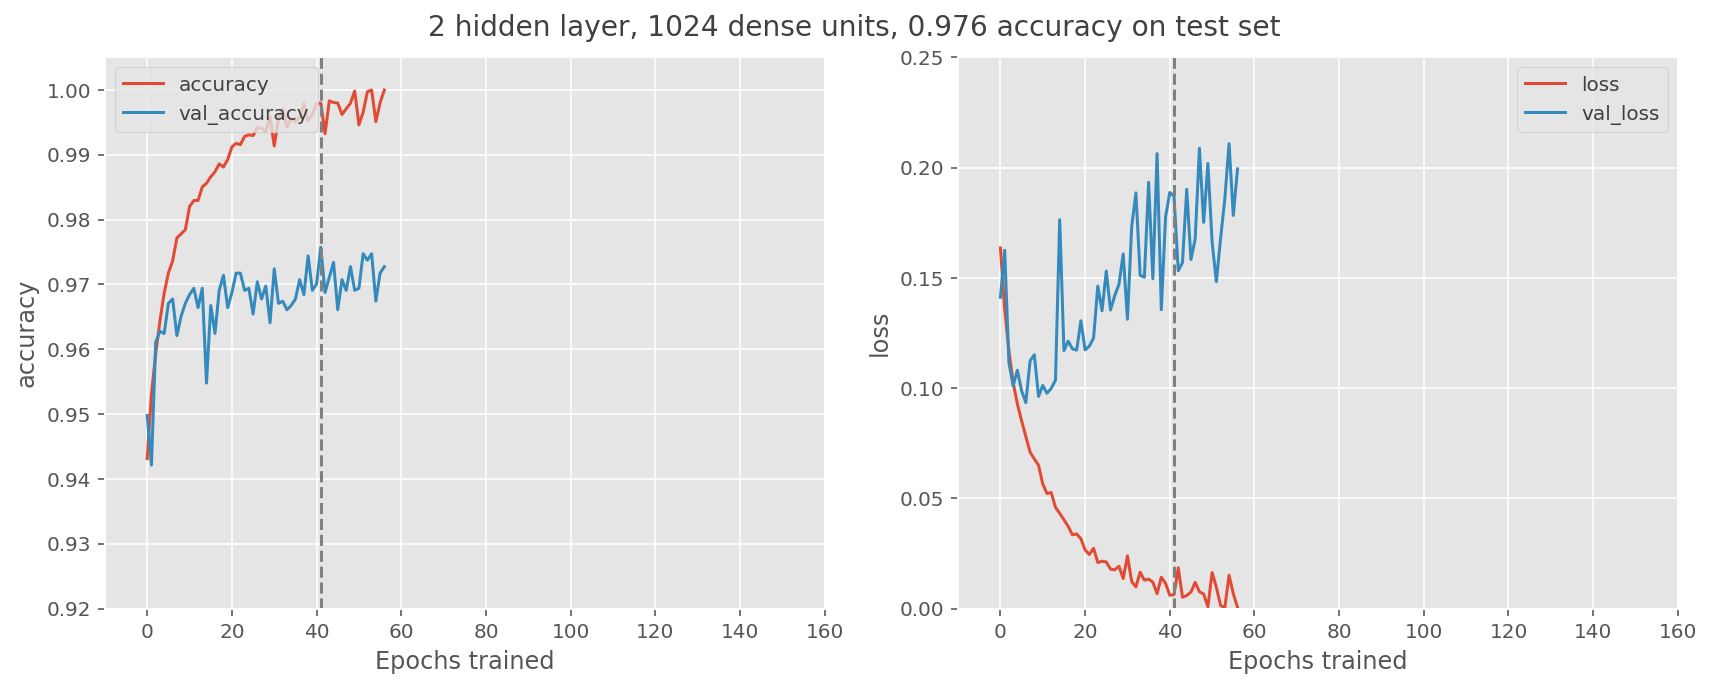

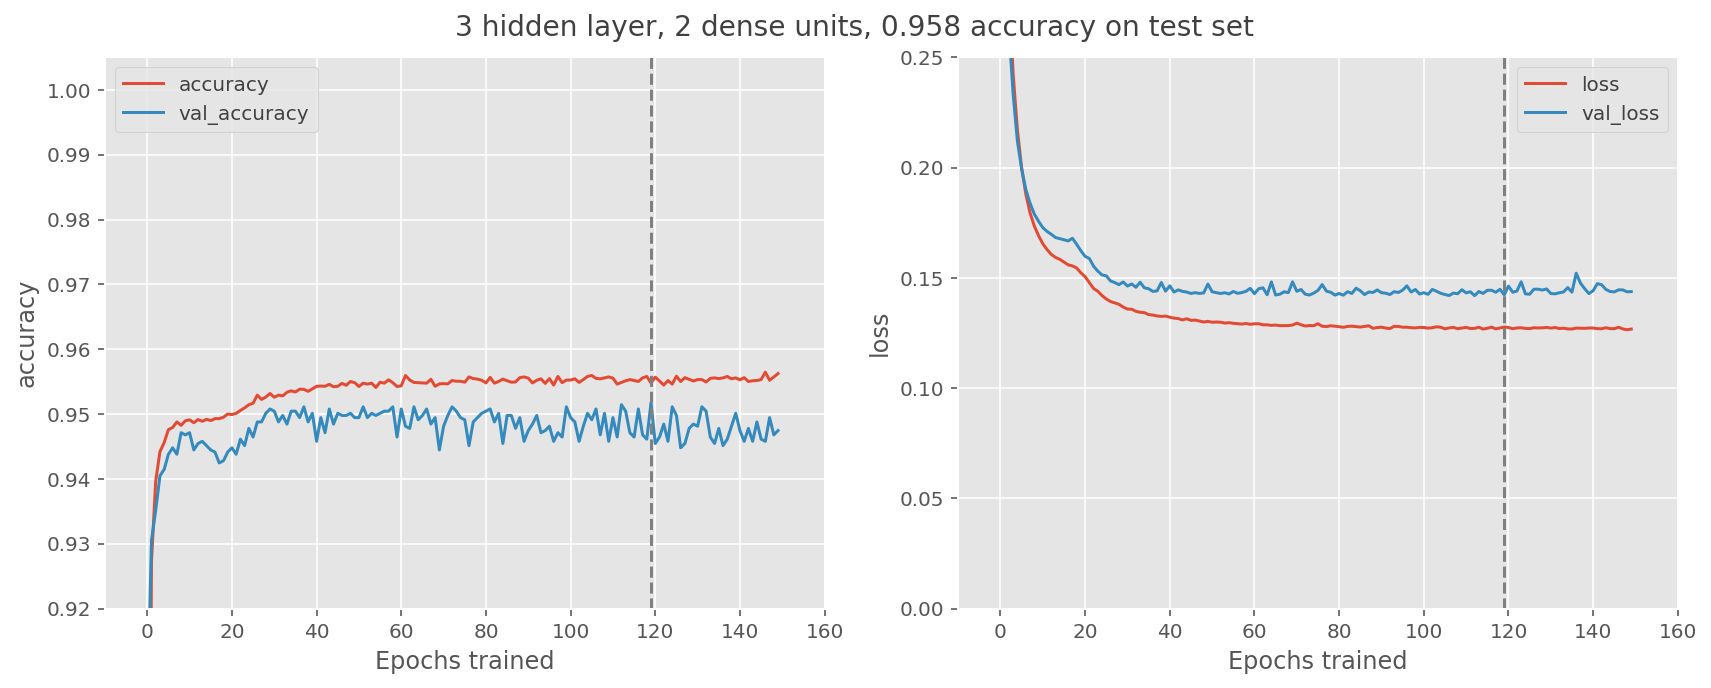

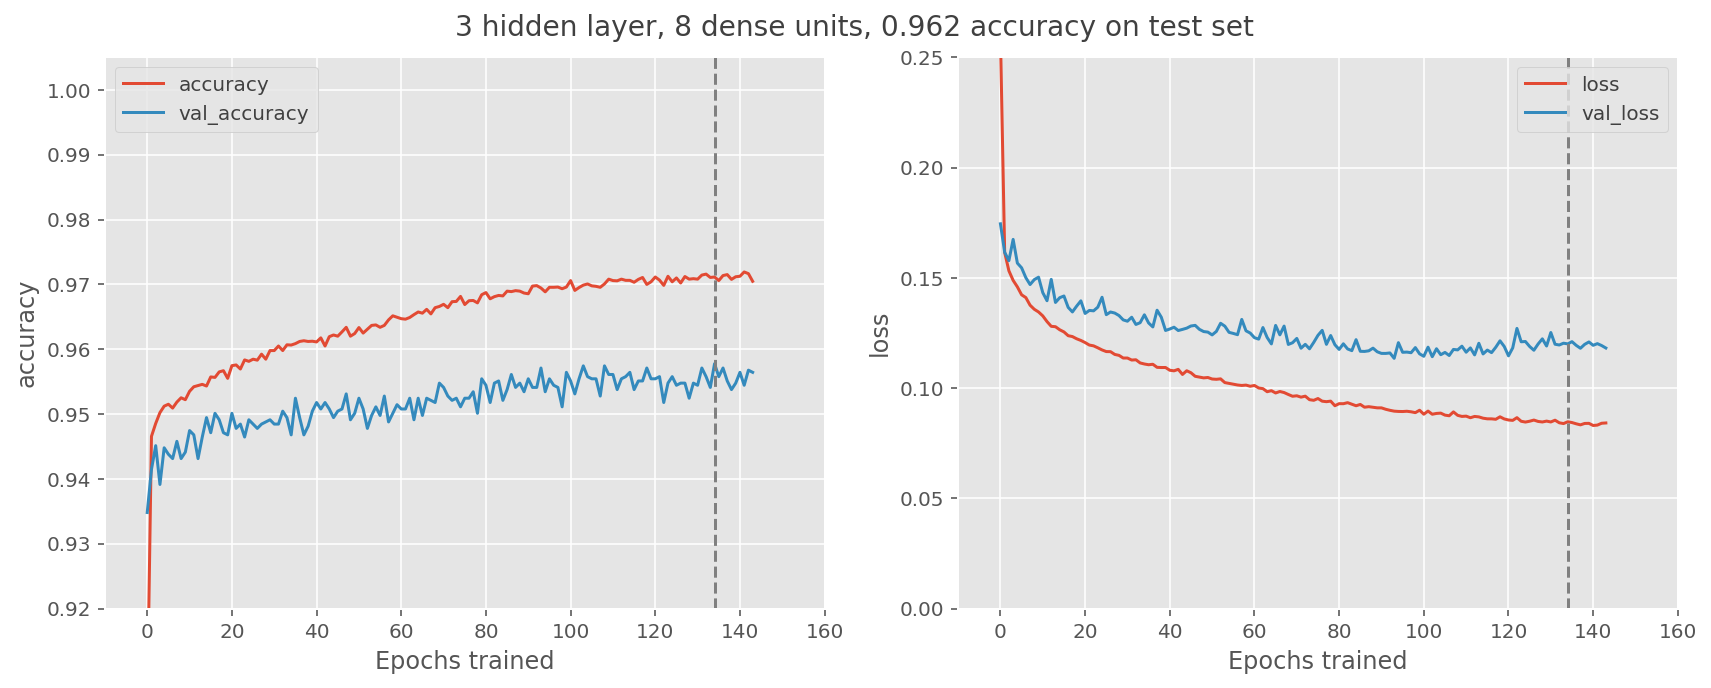

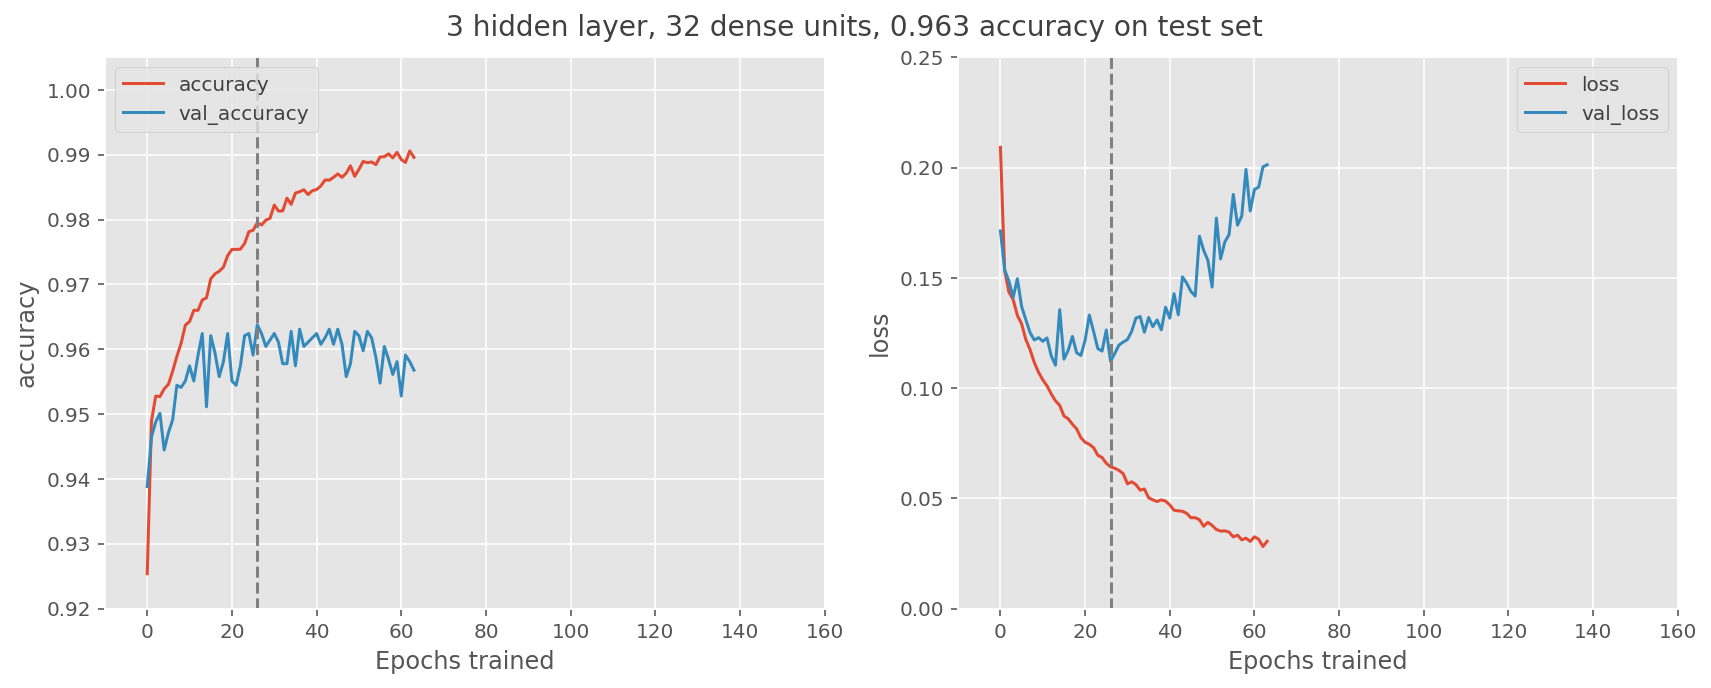

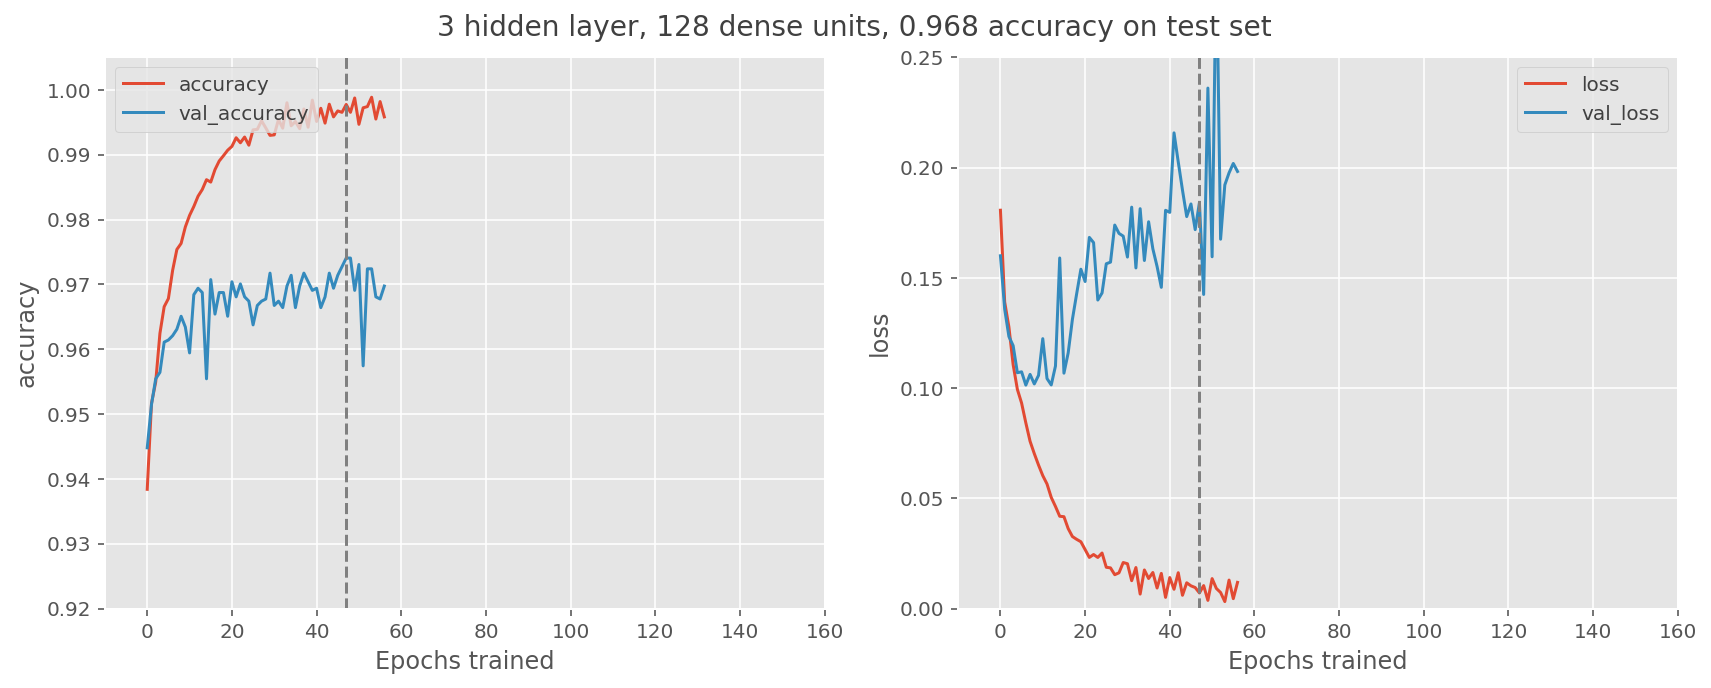

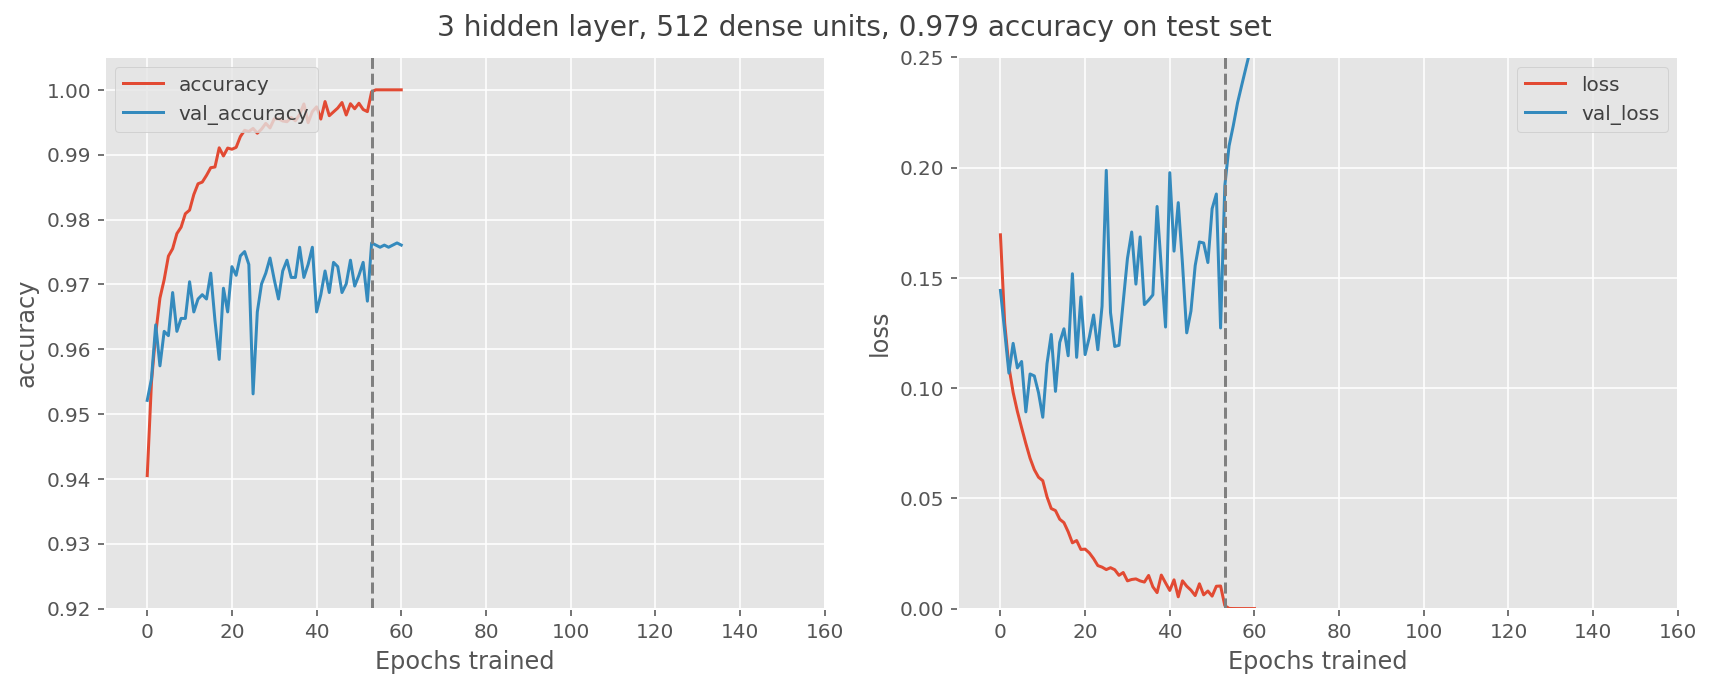

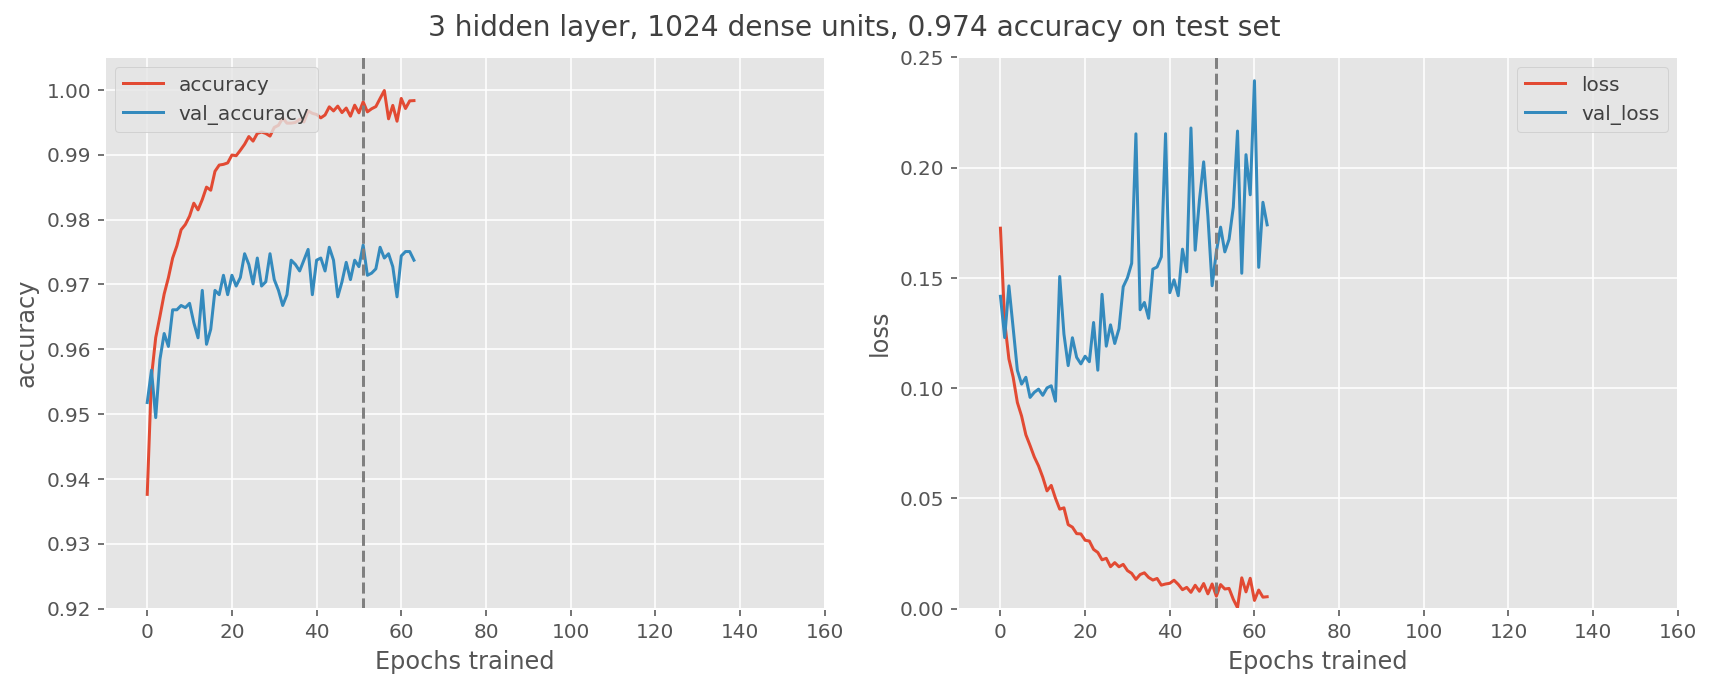

In [23]:
for hist in results:
    accuracy = hist.accuracy_test_set.unique()[0]
    best_epoch = hist.val_accuracy.idxmax()
    YLIM_LOWER = 0.92
    
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    plt.suptitle(f"{hist.hidden_layers.unique()[0]} hidden layer, {hist.dense_units.unique()[0]} dense units, {accuracy:.3f} accuracy on test set", 
                 size=14, y=0.95)

    sns.lineplot(data=hist, x=range(len(hist)), y="accuracy", ax=ax[0])
    sns.lineplot(data=hist, x=range(len(hist)), y="val_accuracy", ax=ax[0])
    ax[0].legend(["accuracy", "val_accuracy"], loc="upper left")
    ax[0].axvline(best_epoch, c="grey", ls="--")

    ax[0].set_ylim(YLIM_LOWER, 1.005)
    ax[0].set_ylabel("accuracy")
    ax[0].set_xlim(-10, EPOCHS+10)
    ax[0].set_xlabel("Epochs trained")
    
    sns.lineplot(data=hist, x=range(len(hist)), y="loss", ax=ax[1])
    sns.lineplot(data=hist, x=range(len(hist)), y="val_loss", ax=ax[1])
    ax[1].legend(["loss", "val_loss"], loc="upper right")
    ax[1].axvline(best_epoch, c="grey", ls="--")
    ax[1].set_ylim(0, 0.25)
    ax[1].set_ylabel("loss")
    ax[1].set_xlim(-10, EPOCHS+10)
    ax[1].set_xlabel("Epochs trained")
    plt.tight_layout()
    plt.show()

## Evaluating the best performing KNN model in detail

In [24]:
def train_model(X_train, y_train, X_test, y_test, cv_folds=5,
                clf=KNeighborsClassifier(n_neighbors=4, weights="distance", metric="manhattan"), 
                report=True):
    
    pipe = make_pipeline(QuantileTransformer(), clf)   
    
    scores = cross_val_score(pipe, X_train, y_train, cv=cv_folds, n_jobs=-1)
    print(f"{np.mean(scores):.3f} accuracy crossvalidated {cv_folds}fold")

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test)
    print(f"{accuracy_score(y_test, y_pred):.3f} accuracy on test set")
    print()
    
    if report == True:
        print(classification_report(y_test, y_pred, zero_division=False))

        cfmtrx = confusion_matrix(y_test, y_pred, normalize="all")
        
        display(pd.DataFrame(cfmtrx, 
                     index=[x + "_true" for x in ["female", "male"]],
                     columns=[x + "_pred" for x in ["female", "male"]]
                    ))
        
    return pipe, y_pred, y_pred_proba

### Score report and confusion matrix
- From the confusion matrix I see that **around 1% male samples are wrongly classified as female ones** and **around 0.5% female samples as male ones.**
- This is according to the report where we have a slightly higher precision for men than for women.

In [25]:
pipe, y_pred, y_pred_proba = train_model(feat_train, meta_train.gender, 
                                         feat_test, meta_test.gender)

0.980 accuracy crossvalidated 5fold
0.982 accuracy on test set

              precision    recall  f1-score   support

      female       0.97      0.99      0.98      2500
        male       0.99      0.97      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



female_pred  male_pred
female_true       0.4946     0.0054
male_true         0.0130     0.4870

In [26]:
tmp = meta_test[["gender", "path"]].copy()
tmp["gender_bool"] = np.where(tmp.gender=="male", True, False)
tmp["predicted"] = y_pred
tmp["predicted_proba"] = y_pred_proba.max(axis=1)
tmp["wrong_predictions"] = np.where(tmp.gender!=tmp.predicted, True, False)

### Examining the prediction probabilities
- From plotting the distribution of predicted probabilities I notice **distinct clusters around 0.5, 0.75 and exactly 1.**
- This is because the probabilities that KNN predicts are frations of votes among the nearest neighbors. If we were to train with more `n_neighbors` we'd get more evenly distributed probabilities across the spectrum between 0 and 1.
- **I plot the wrong predictions as grey points below the main stripplot. However, I do not notice particular patterns. The classifier has made wrong predictions in all the probability clusters.**

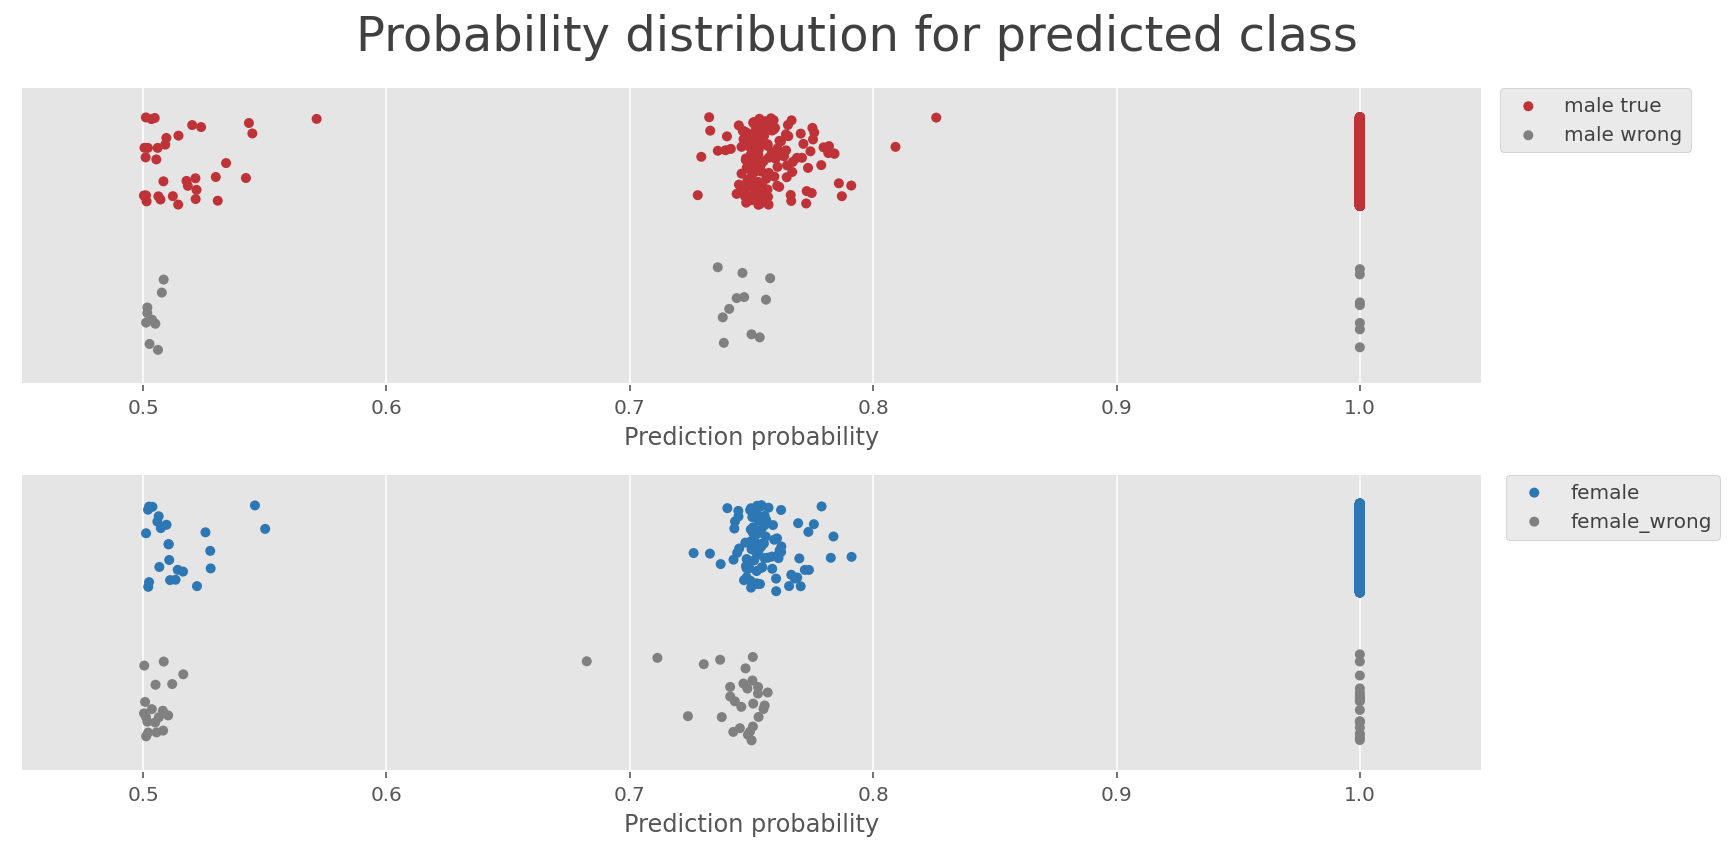

In [27]:
_, (ax1,ax2) = plt.subplots(2,1, figsize=(12,6))
plt.suptitle("Probability distribution for predicted class", size=24)
sns.set_palette(sns.color_palette([COLOR_MALE, "grey"]))
sns.stripplot(data=tmp[tmp.predicted=="male"], x="predicted_proba", y="wrong_predictions", orient="horizontal", ax=ax1, jitter=0.3)
sns.set_palette(sns.color_palette([COLOR_FEMALE, "grey"]))
sns.stripplot(data=tmp[tmp.predicted=="female"], x="predicted_proba", y="wrong_predictions", orient="horizontal", ax=ax2, jitter=0.3)
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_xlim(0.45, 1.05)
ax2.set_xlim(0.45, 1.05)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.set_xlabel("Prediction probability")
ax2.set_xlabel("Prediction probability")
ax1.legend(["male true", "male wrong"], bbox_to_anchor=(1.15, 1.03), loc='upper right')
ax2.legend(["female", "female_wrong"], bbox_to_anchor=(1.17, 1.03), loc='upper right')
plt.tight_layout()
plt.show()

### Examining wrong predictions
I examined **wrong predictions where KNN is either very sure or unsure in its (wrong) prediction**:
- **I can't observe a clear pattern or a particular reason for every wrong sample.** 
- Some of the samples have **very low audio quality** and/or **substantial background noise**. Some others come from **men with unusual high voices**. Some of the wrongly predicted female samples are louder than average. I found **one sample of a teenager** as well. 

In [28]:
low_threshold = 0.55
low_proba = tmp[(tmp.predicted_proba < low_threshold) & (tmp.gender!=tmp.predicted)].dropna().index
print(f"{len(low_proba)} wrong predictions with probability below {low_threshold} found.")
low_proba = tmp.loc[low_proba]

!rm _data/_false_low_proba/*

for file in low_proba.path.values:
    file_path = "_data/CommonVoice/_german/clips/" + file
    destination = f"_data/_false_low_proba/{file}"
    copyfile(file_path, destination)

27 wrong predictions with probability below 0.55 found.


In [29]:
high_threshold = 0.95
high_proba = tmp[(tmp.predicted_proba > high_threshold) & (tmp.gender!=tmp.predicted)].dropna().index
print(f"{len(high_proba)} wrong predictions with probability above {high_threshold} found.")
high_proba = tmp.loc[high_proba]

!rm _data/_false_high_proba/*

for file in high_proba.path.values:
    file_path = "_data/CommonVoice/_german/clips/" + file
    destination = f"_data/_false_high_proba/{file}"
    copyfile(file_path, destination)

26 wrong predictions with probability above 0.95 found.


- Plotting the UMAP'ed features and colorizing by gender indicates two distinct clusters and several peculiar samples that are in the wrong cluster. 
- I too plot the wrong predictions as black markers. From that I see that these peculiar samples aren't the necessarily wrong predictions. Rather, the errors are distributed more or less evenly across the sample space.

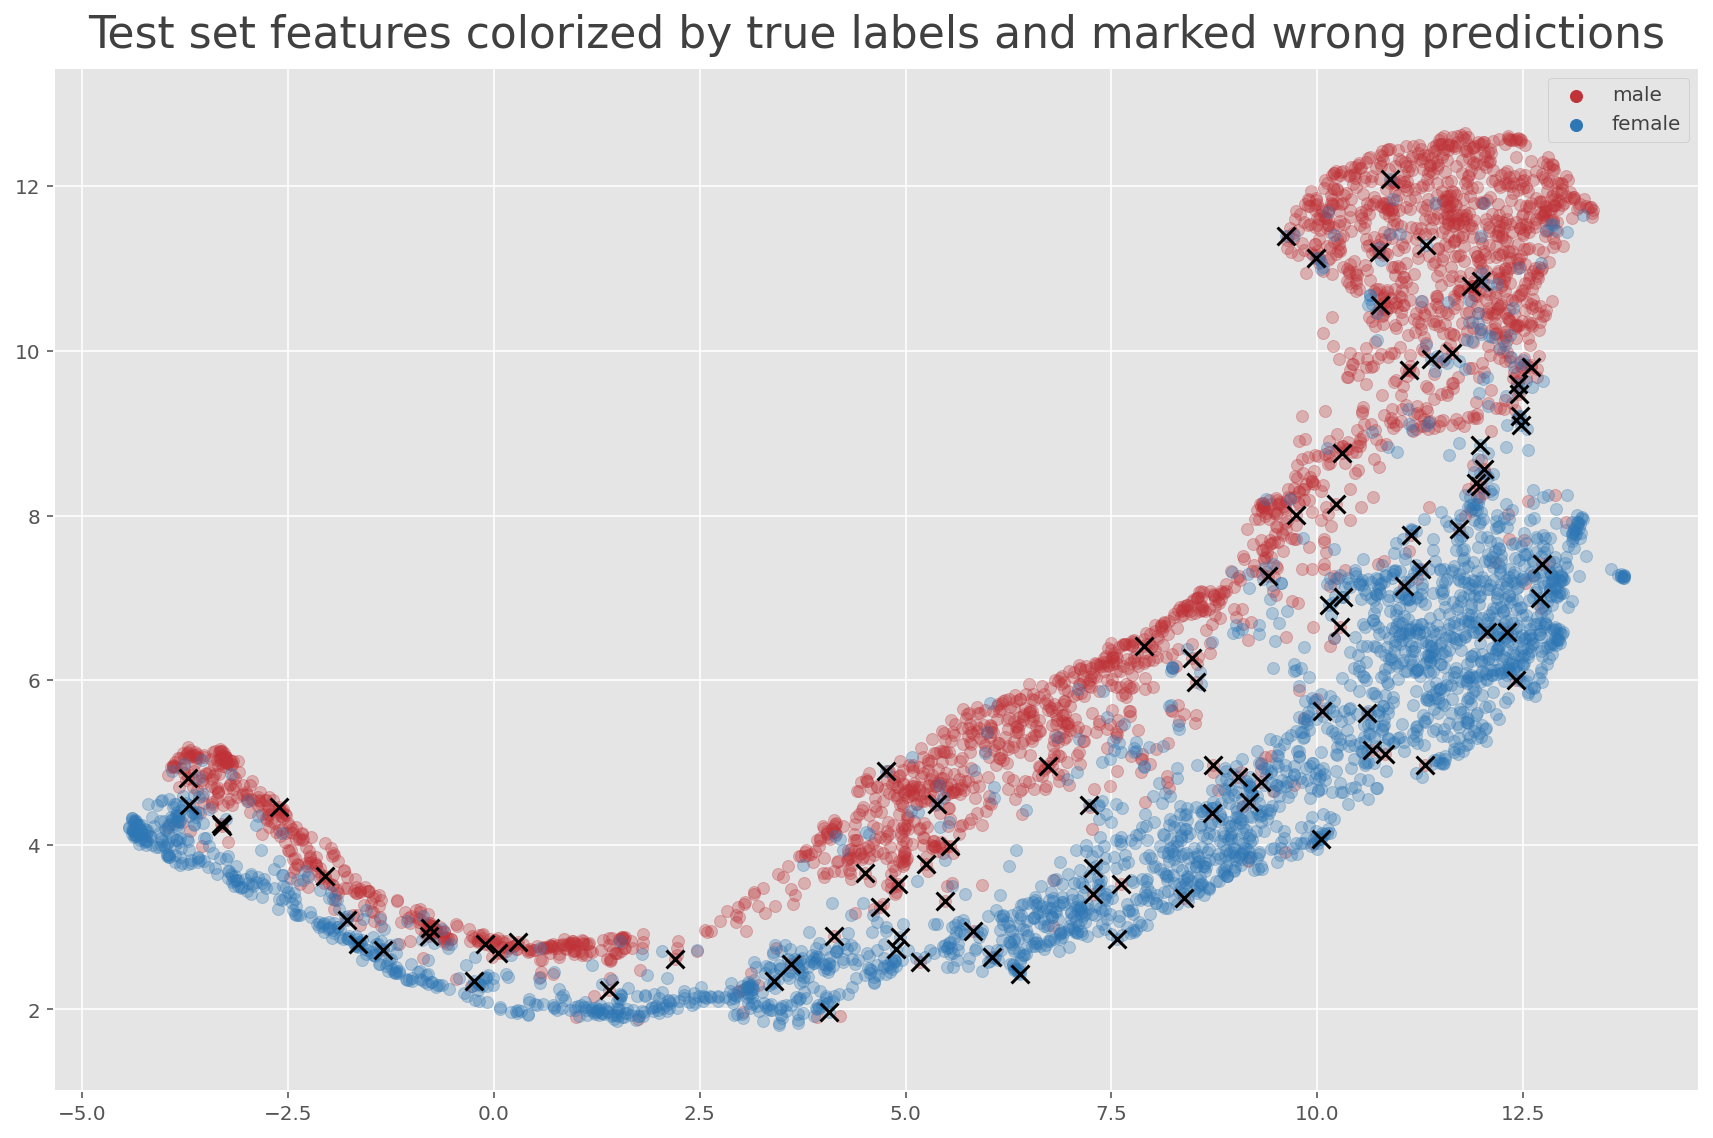

In [30]:
_ = umap_reduce_and_plot(feat_test, 
                         labels=tmp.gender_bool, 
                         extra_markers=tmp.wrong_predictions,
                         title="Test set features colorized by true labels and marked wrong predictions", 
                         alpha=.3)

### How much do the tuned classifiers agree / disagree in their predictions?
- There obviously is some overlap in the errors the classifiers make. 
- At the same time the classifiers differ substiantially.

Calculating the ratio of error accordance confirms this:
- **58% of errors of all wrong predictions are unique to one classifier.**
- For 22% of all errors two classifiers make the same mistakes.
- For 10% and 11% either 3 or all 4 classifiers are in accordance in their wrong prediction.

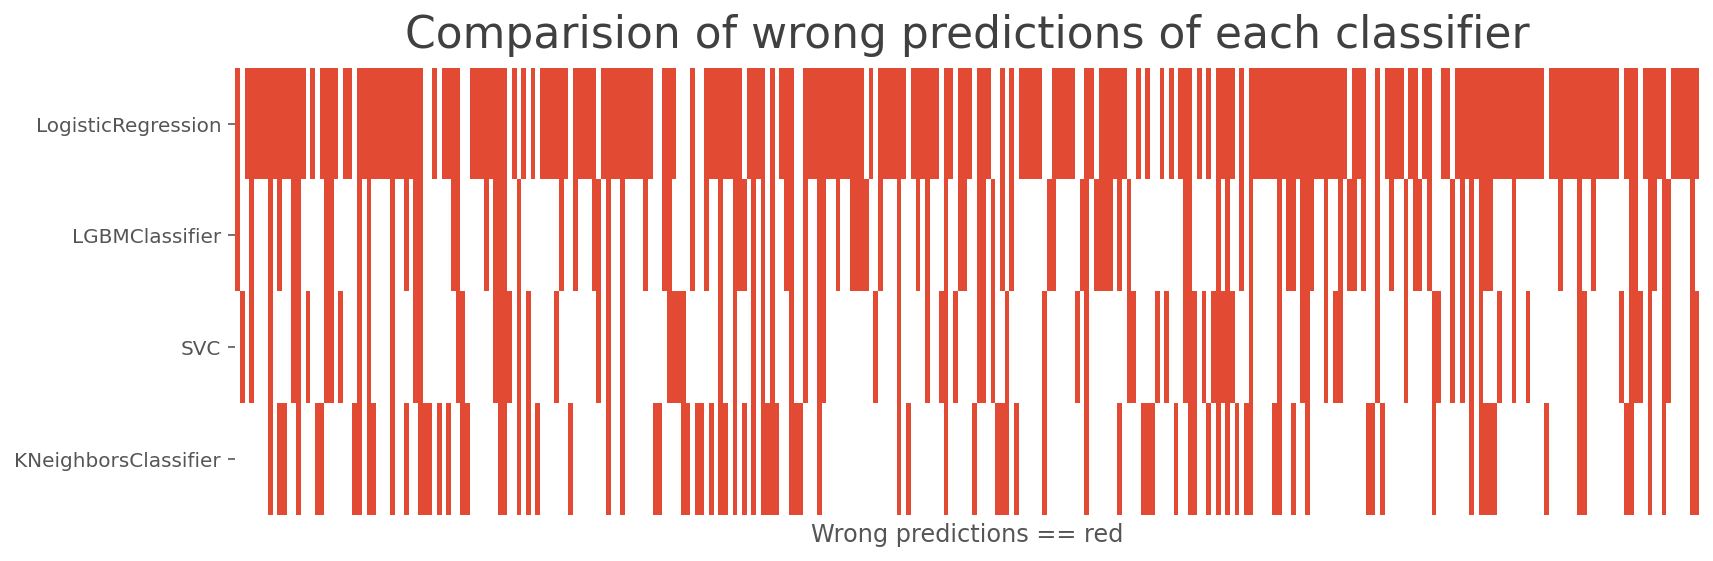


Accordance of wrong predictions of tuned classifiers
-  ----
1  0.58
2  0.22
3  0.10
4  0.11
-  ----


In [31]:
# get wrong predictions from array of all fitted classifiers trained with best params
wrong_predictions = []
for grid in grids:
    if grid==None:
        continue
    y_pred = grid.predict(feat_test)
    wrong_predictions.append(np.where(meta_test.gender!=y_pred, True, False))

# get names of classifiers
clfs = [str(grid.param_grid[0]["estimator"][0]).split("(")[0] for grid in grids if grid!=None]   

df_wrong = pd.DataFrame(wrong_predictions)
df_wrong.index = clfs
# keep all predictions where there is at least one wrong prediction of any of the classifiers
df_wrong = df_wrong.loc[:, df_wrong.sum(axis=0)>0]

idx = ['LogisticRegression', 'LGBMClassifier', 'SVC', 'KNeighborsClassifier']
df_wrong = df_wrong.reindex(idx)

plt.figure(figsize=(12,4))
sns.heatmap(df_wrong, cbar=False, cmap=sns.color_palette(['white', "#E24A33"]))
plt.xticks([])
plt.xlabel("Wrong predictions == red")
plt.title("Comparision of wrong predictions of each classifier", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.tight_layout()
plt.show()

print()
print("Accordance of wrong predictions of tuned classifiers")
print(tabulate(df_wrong.sum().value_counts(normalize=True).sort_index().to_frame(), floatfmt=".2f"))

# 2) Final overview of all results

In [32]:
plt.style.use('ggplot')

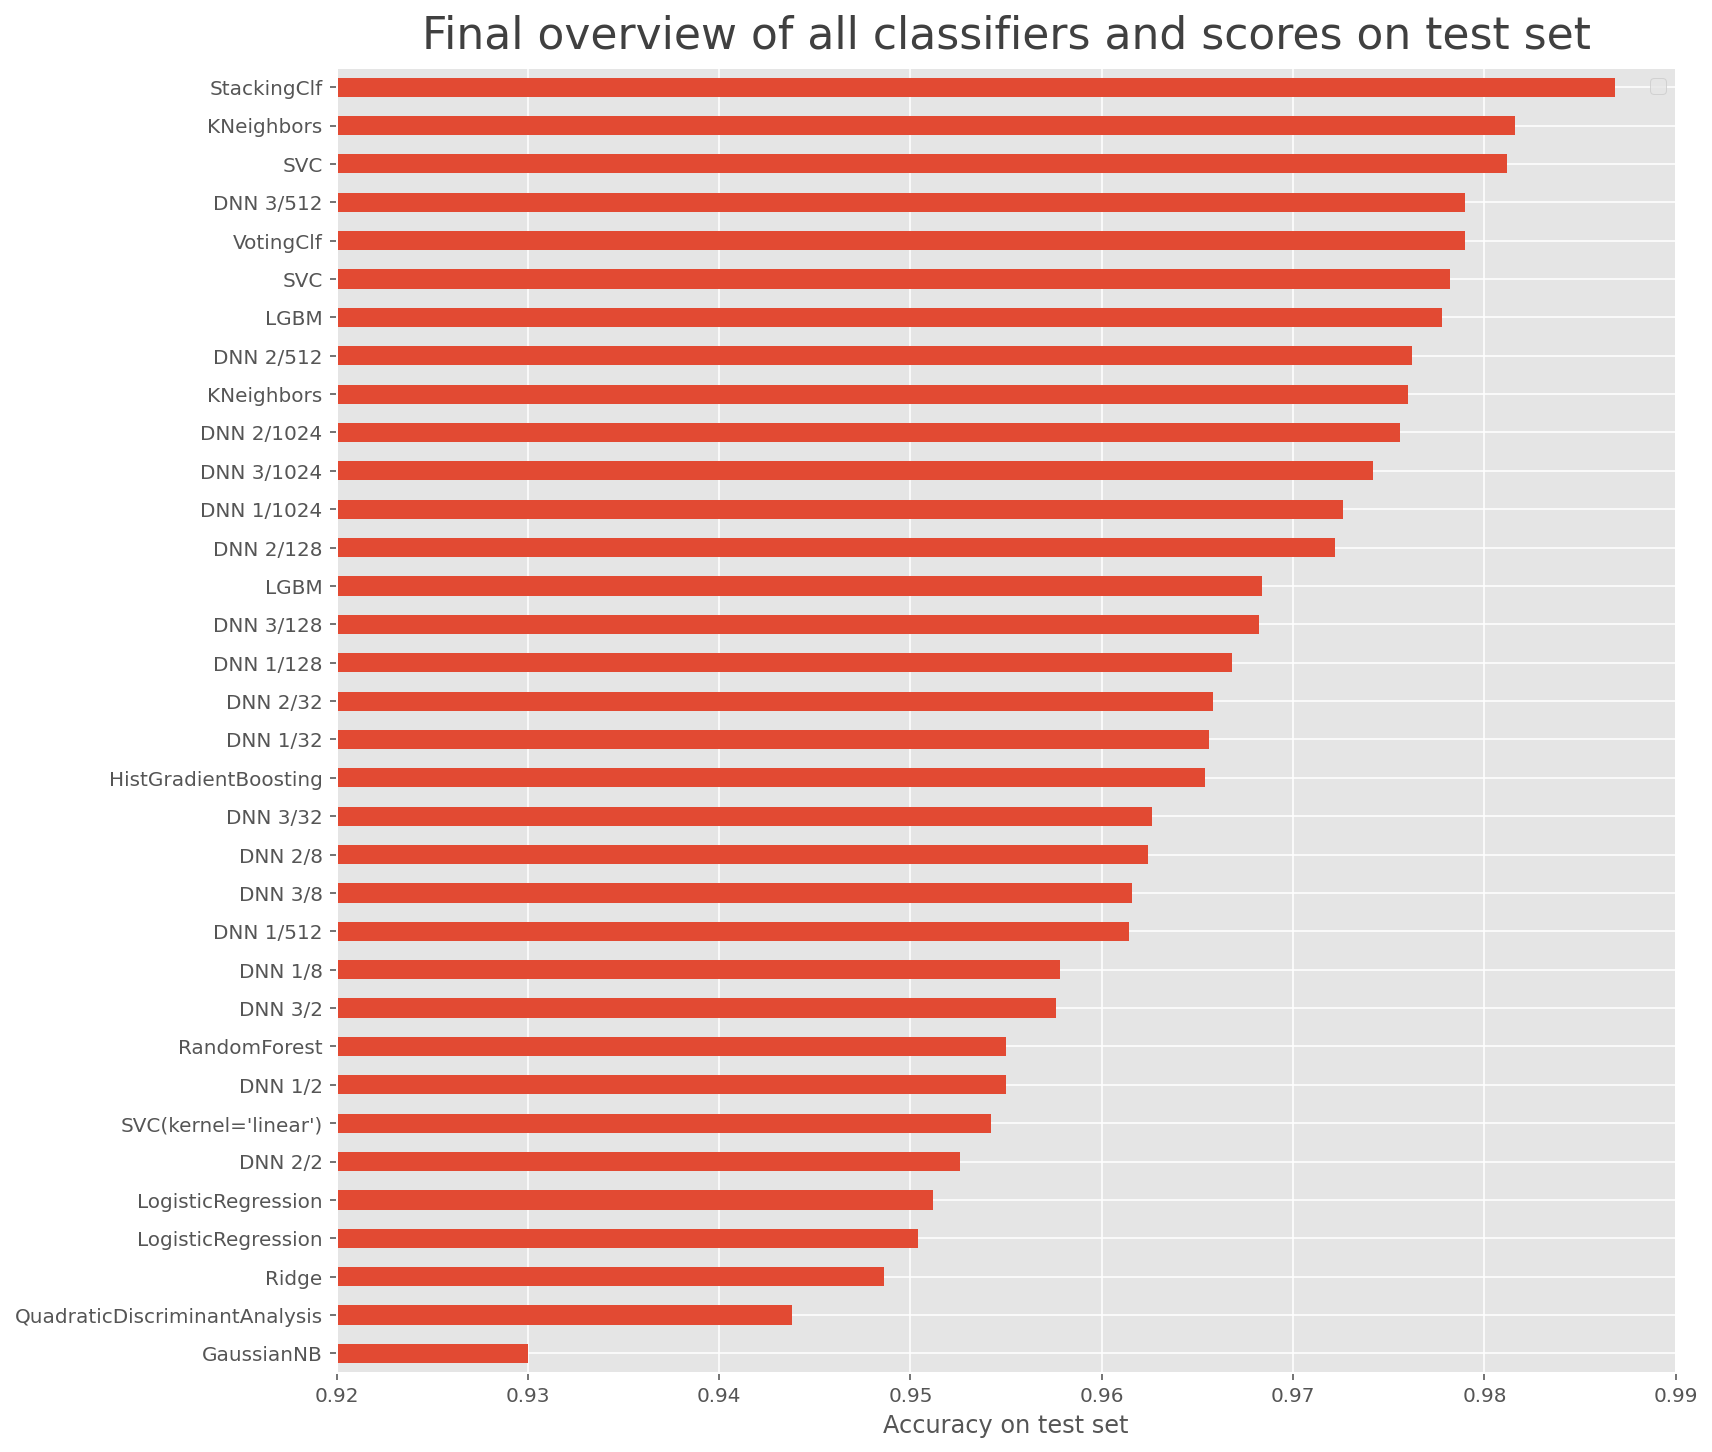

In [33]:
df = pd.DataFrame(test_set_scores, columns=["classifier", "tuned", "accuracy"])
df.sort_values("accuracy").iloc[1:].plot.barh(x="classifier", y="accuracy", figsize=(12,12))
plt.ylabel("")
plt.xlabel("Accuracy on test set")
plt.xlim(0.92, 0.99)
plt.title("Final overview of all classifiers and scores on test set", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.legend("")
plt.show()

# 3) Conclusions

**Tuning the hyperparameters in general brought only marginal improvements.** 
- One explanation is that the data set is of adequate quality for the task and the remaining error rate is due to hard samples that aren't predictable with the extracted features. To improve I would have to extract additional features, anaylyze longer segments (now 2secs) or probably use sequential models that can take into account the vocal melody and expressiveness of a particular speaker.

**KNN performs well.**
- KNN out of the box and tuned performs astonishingly well and trains fast. 
- Inference is comparably slow though (roughly 100x slower than e.g. Logistic regression). Since I train the model once and do a lot of inference this can be a factor to consider if I wanted to productionize the model. 

**Tree based learners performed worse than expected.**
- Randomforest, LightGBM and HistGradientBoostingClassifier yielded results under par or below the top. Given their ubiquity at data science competition platforms I would have expected better accuracy and speed. My guess (and it really is a just a vage guess) is that this is because I only have continuous numerical features of two types (FO and MFCC). Tree based learners may have more advantages when the data has more diverse features and more diverse data type (continuous, categorical).

**The dense neural networks performed less good than the top «traditional» classifiers.**
- The best DNN couldn't outperform the KNN and SVC. My assumption is that I either haven't found the perfect architecture yet (no of hidden layers, dropout etc.) or that I need more data to help a DNN unfold its strengths.